In [1]:
import matplotlib .pyplot as plt
from clickhouse_connect import get_client
import seaborn as sns
import pandas as pd
import numpy as np

In [2]:
# Only if you have xatu-data in advance
client = get_client(host='localhost', port=8123)

In [3]:
slot_pectra = 11649024
block_pectra = 22431084

slot_36m_start= 10902052
slot_36m_end = 10987142

slot_45m_start = 12133906
slot_45m_end = 12190166

slot_start = 10738799
slot_end = 12459615

block_start = 21525891
block_end = 23235912

In [4]:
total_df_1 = pd.read_pickle("../data/total_df_1")
total_df_2 = pd.read_pickle("../data/total_df_2")
total_df = pd.concat([total_df_1, total_df_2], axis=0, ignore_index=True)

In [5]:
plot_df = total_df[(total_df['block_prop_libp2p']!=0)]

# Reorg rate change

0.12244425201453889 0.11209788143693844
1110 906535
903 805546


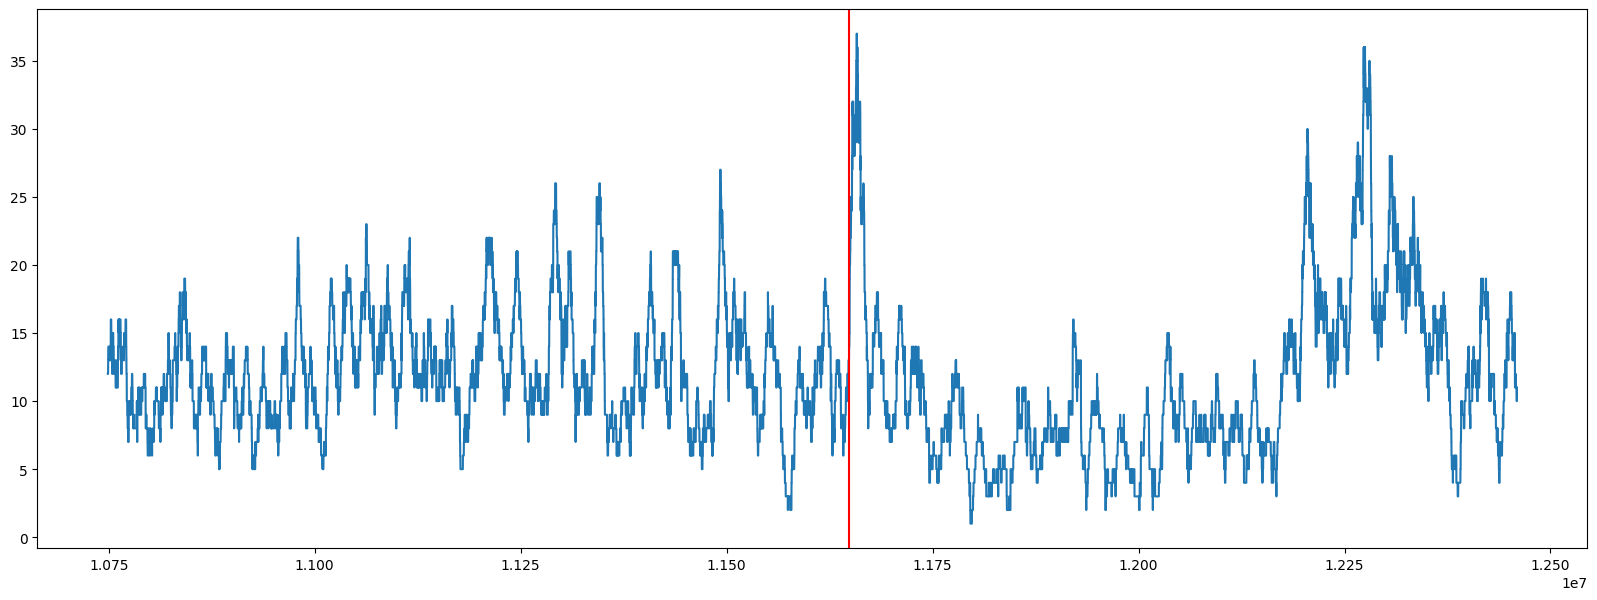

In [6]:
plt.figure(figsize=(20,7))
plt.plot(total_df['slot'], total_df['reorg_flag'].rolling(window=10000).sum())
plt.axvline(slot_pectra, color='r')

print(100*total_df[total_df['slot']<slot_pectra]['reorg_flag'].mean(), \
100*total_df[total_df['slot']>=slot_pectra]['reorg_flag'].mean())

print(total_df[total_df['slot']<slot_pectra]['reorg_flag'].sum(), len(total_df[total_df['slot']<slot_pectra]))
print(total_df[total_df['slot']>=slot_pectra]['reorg_flag'].sum(), len(total_df[total_df['slot']>=slot_pectra]))

# Reorg factors

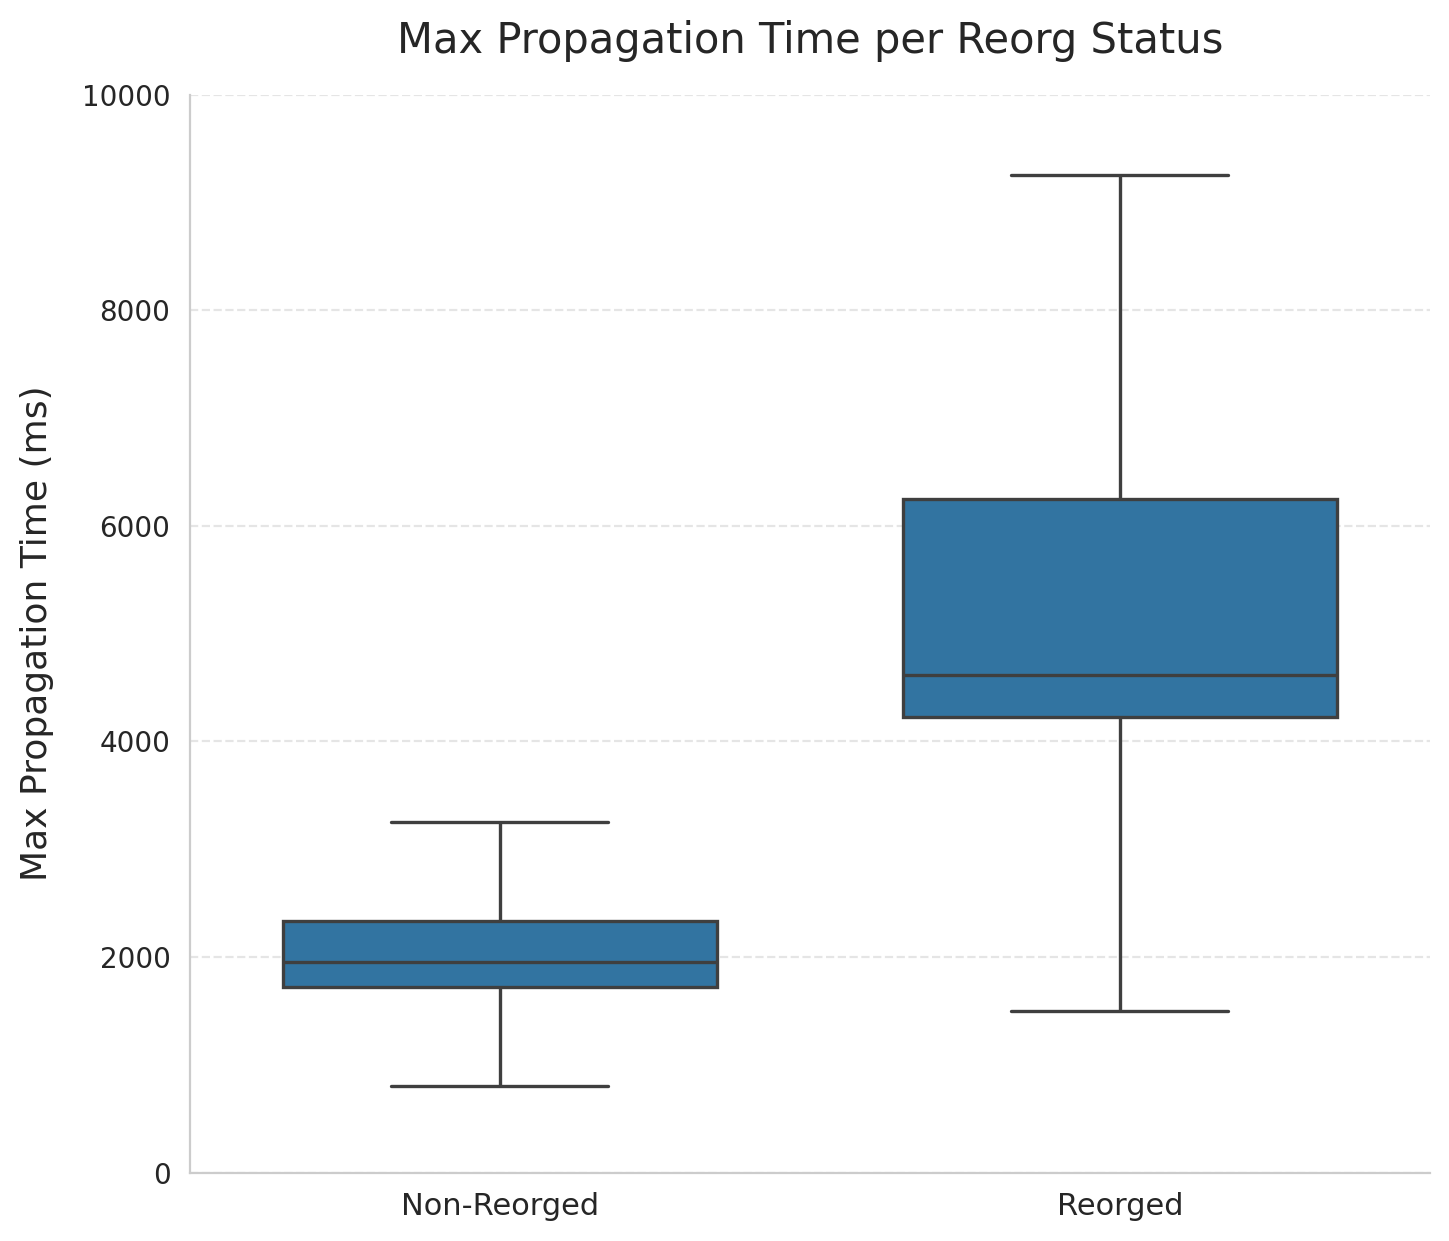

In [7]:
import matplotlib.patches as mpatches

plt.figure(figsize=(8,7), dpi=200)
sns.set_style("whitegrid")

ax = sns.boxplot(  
    x="reorg_flag",
    y="max_prop",
    data=plot_df,
    showfliers=False,
    width=0.7,
    linewidth=1.2,
)

plt.ylabel("Max Propagation Time (ms)", fontsize=13, labelpad=10)
plt.title("Max Propagation Time per Reorg Status", fontsize=15, pad=15)
plt.ylim(0, 10000)
plt.xticks([0, 1], ["Non-Reorged", "Reorged"], fontsize=11)
plt.grid(axis="y", linestyle="--", alpha=0.5)
ax.set_xlabel("")
sns.despine(left=False, bottom=False)
colors = [patch.get_facecolor() for patch in ax.patches[:2]]
plt.show()

### Visulaization

In [8]:
plot_df = total_df[['slot','block_prop_libp2p','max_blob_prop','gas_used','validator_count','reorg_flag']].copy()

# Check missing values
print(plot_df.isna().sum())

# Basic descriptive statistics
print(plot_df.describe())

# How many reorgs vs non-reorgs
print(plot_df['reorg_flag'].value_counts(normalize=True))

slot                    0
block_prop_libp2p       0
max_blob_prop           0
gas_used             5139
validator_count         0
reorg_flag              0
dtype: int64
               slot  block_prop_libp2p  max_blob_prop         gas_used  \
count  1.712081e+06       1.712081e+06   1.712081e+06        1706942.0   
mean   1.159886e+07       2.008633e+03   1.521275e+03  18478741.862254   
std    4.968310e+05       6.026413e+02   1.107649e+03   8387965.518542   
min    1.073880e+07       0.000000e+00   0.000000e+00              0.0   
25%    1.116862e+07       1.644000e+03   0.000000e+00      12860746.75   
50%    1.159813e+07       1.861000e+03   1.809000e+03       17168096.5   
75%    1.202941e+07       2.225000e+03   2.173000e+03       23027946.0   
max    1.245922e+07       1.200000e+04   1.198300e+04       45216649.0   

       validator_count    reorg_flag  
count     1.712081e+06  1.712081e+06  
mean      1.063337e+06  1.175762e-03  
std       1.191497e+04  3.426923e-02  
min     

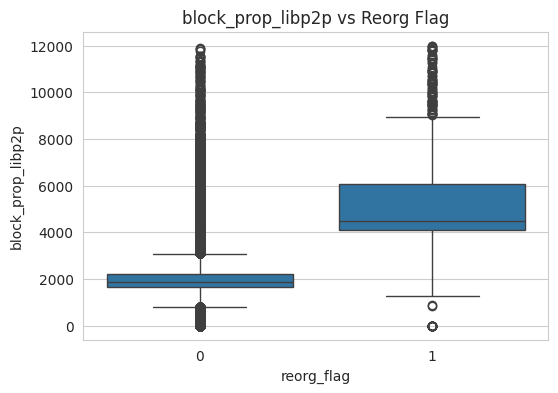

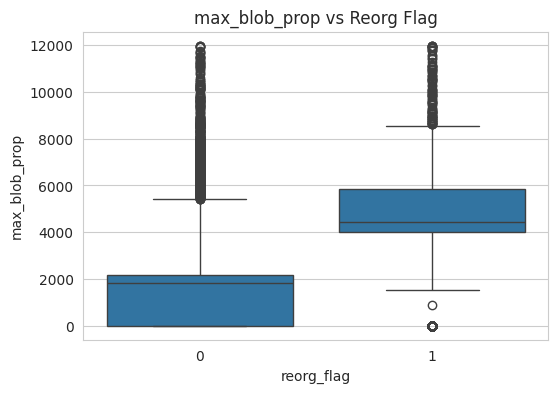

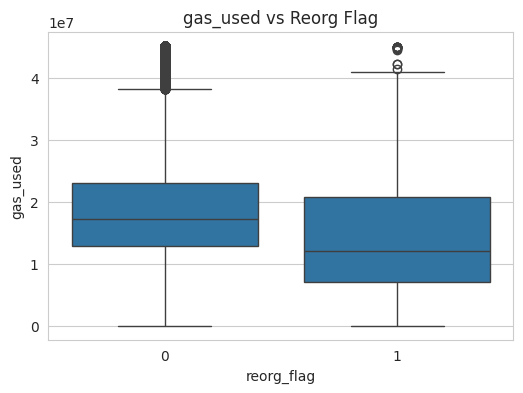

In [9]:
for col in ['block_prop_libp2p','max_blob_prop','gas_used']:
    plt.figure(figsize=(6,4))
    sns.boxplot(x='reorg_flag', y=col, data=plot_df)
    plt.title(f'{col} vs Reorg Flag')
    plt.show()

                   block_prop_libp2p  max_blob_prop  gas_used  validator_count
block_prop_libp2p           1.000000       0.442514  0.126425         0.006548
max_blob_prop               0.442514       1.000000  0.034792        -0.016924
gas_used                    0.126425       0.034792  1.000000         0.043958
validator_count             0.006548      -0.016924  0.043958         1.000000


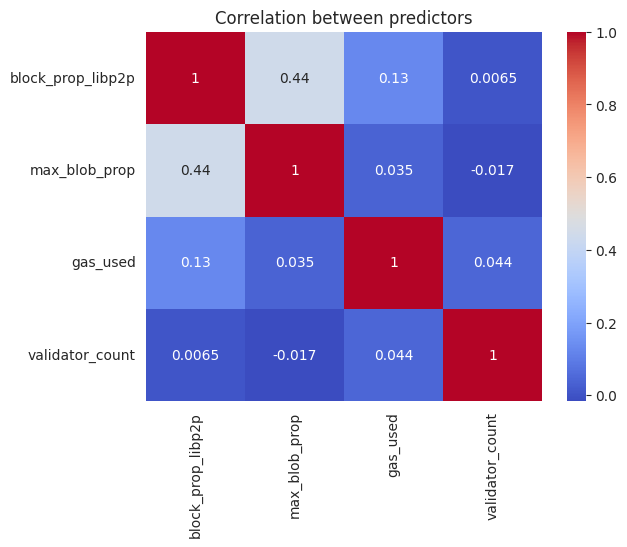

In [10]:
print(plot_df[['block_prop_libp2p','max_blob_prop','gas_used','validator_count']].corr())
sns.heatmap(plot_df[['block_prop_libp2p','max_blob_prop','gas_used','validator_count']].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation between predictors')
plt.show()

## logistic regression

In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import train_test_split

plot_df['log_block_prop'] = np.log1p(plot_df['block_prop_libp2p'])
plot_df['log_max_blob'] = np.log1p(plot_df['max_blob_prop'])

X = plot_df[['log_block_prop', 'log_max_blob']]
y = plot_df['reorg_flag']

# Split into train/test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

model = LogisticRegression(class_weight='balanced', solver='liblinear')
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:,1]

# Evaluation
print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_prob))


coeff_df = pd.DataFrame({
    'feature': X.columns,
    'coefficient': model.coef_[0],
    'odds_ratio': np.exp(model.coef_[0])
})
print(coeff_df)

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.
              precision    recall  f1-score   support

           0       1.00      0.92      0.96    342014
           1       0.01      0.97      0.03       403

    accuracy                           0.92    342417
   macro avg       0.51      0.95      0.49    342417
weighted avg       1.00      0.92      0.96    342417

ROC-AUC: 0.9795512484716681
          feature  coefficient  odds_ratio
0  log_block_prop     3.512110   33.518915
1    log_max_blob     0.067538    1.069871


## Reorg VS max_prop

/tmp/ipykernel_78285/4084098218.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  prob_by_bin_raw = plot_df.groupby('bin_raw')['reorg_flag'].mean().reset_index()


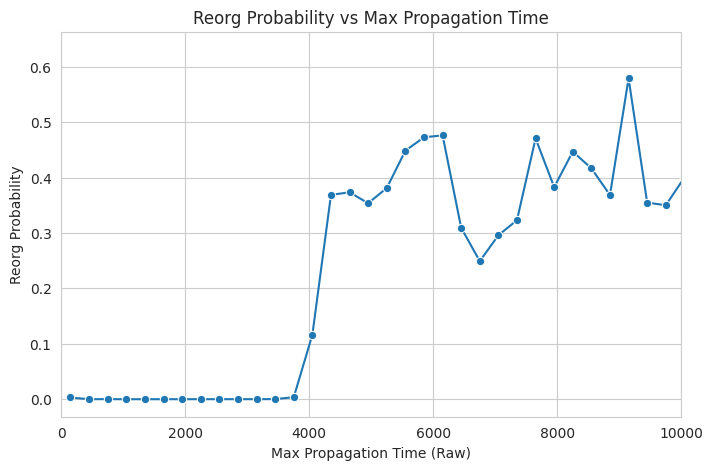

In [13]:
plot_df['max_prop'] = plot_df[['block_prop_libp2p', 'max_blob_prop']].max(axis=1)

# Use raw block propagation time
plot_df['bin_raw'] = pd.cut(plot_df['max_prop'], bins=40)

# Compute mean reorg probability in each bin
prob_by_bin_raw = plot_df.groupby('bin_raw')['reorg_flag'].mean().reset_index()
prob_by_bin_raw['bin_center'] = prob_by_bin_raw['bin_raw'].apply(lambda x: x.mid)

# Plot
plt.figure(figsize=(8,5))
sns.lineplot(x='bin_center', y='reorg_flag', data=prob_by_bin_raw, marker='o')
plt.xlim(0,10000)
plt.xlabel('Max Propagation Time (Raw)')
plt.ylabel('Reorg Probability')
plt.title('Reorg Probability vs Max Propagation Time')
plt.show()

/tmp/ipykernel_78285/3408690491.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  plot_df.groupby('bin_raw')['reorg_flag']


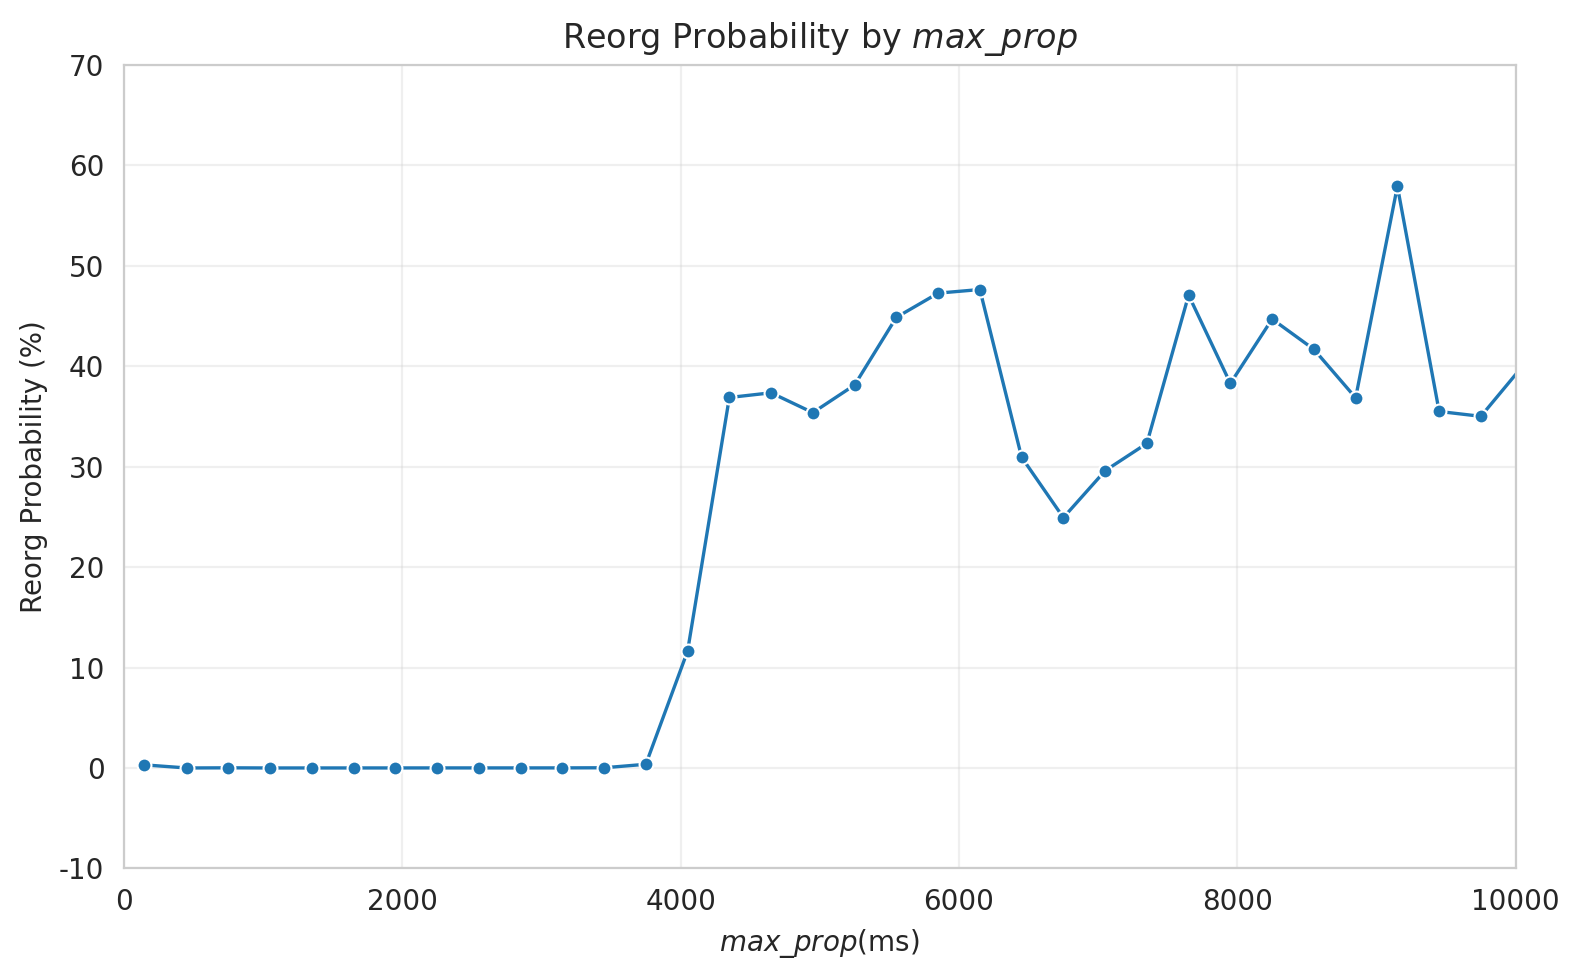

In [24]:
import matplotlib.ticker as mticker

plot_df['max_prop'] = plot_df[['block_prop_libp2p', 'max_blob_prop']].max(axis=1)
plot_df['bin_raw'] = pd.cut(plot_df['max_prop'], bins=40)

prob_by_bin_raw = (
    plot_df.groupby('bin_raw')['reorg_flag']
    .mean()
    .reset_index()
)
prob_by_bin_raw['bin_center'] = prob_by_bin_raw['bin_raw'].apply(lambda x: x.mid)

plt.figure(figsize=(8,5),dpi=200)
sns.set_style("whitegrid")

sns.lineplot(
    x='bin_center',
    y='reorg_flag',
    data=prob_by_bin_raw,
    marker='o',
    markersize=5,
    linewidth=1.2
)

plt.xlim(0, 10000)
plt.xlabel('$\\it{max\\_prop}$(ms)')
plt.ylabel('Reorg Probability (%)')
plt.title('Reorg Probability by $\\it{max\\_prop}$')

ax = plt.gca()
yticks = ax.get_yticks()
ax.set_yticks(yticks)
ax.set_yticklabels([f"{y*100:.0f}" for y in yticks])

plt.grid(axis='y', alpha=0.3)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

/tmp/ipykernel_78285/1227683563.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  plot_df.groupby('bin_raw')['reorg_flag']


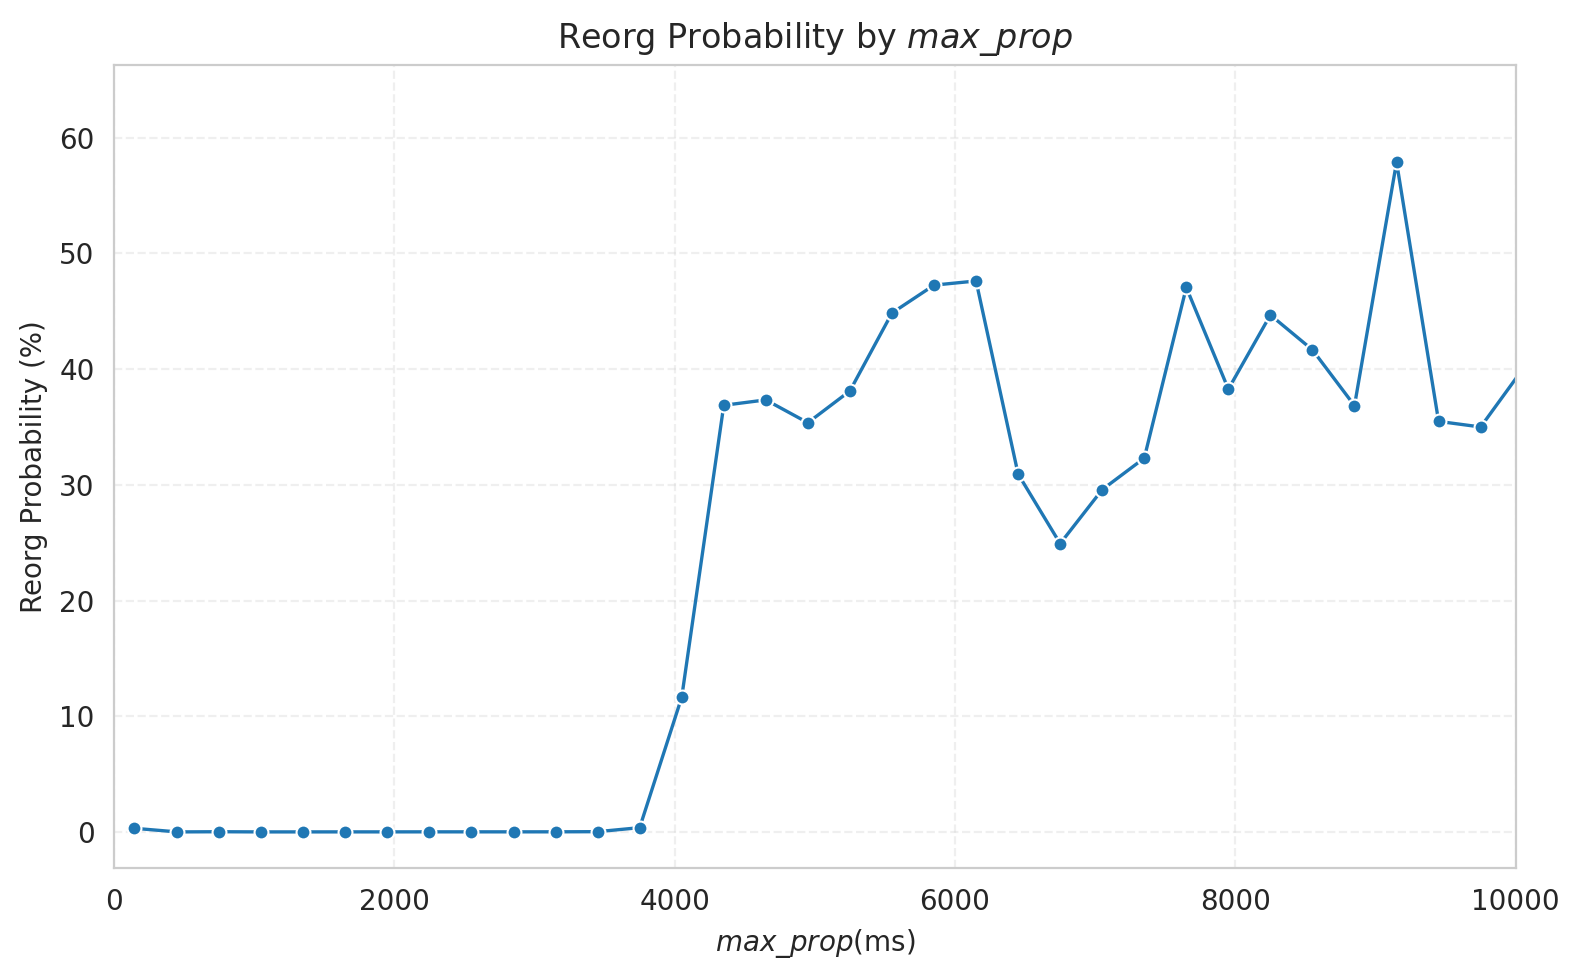

In [25]:
plot_df['max_prop'] = plot_df[['block_prop_libp2p', 'max_blob_prop']].max(axis=1)
plot_df['bin_raw'] = pd.cut(plot_df['max_prop'], bins=40)

prob_by_bin_raw = (
    plot_df.groupby('bin_raw')['reorg_flag']
    .mean()
    .reset_index()
)
prob_by_bin_raw['bin_center'] = prob_by_bin_raw['bin_raw'].apply(lambda x: x.mid)
prob_by_bin_raw['reorg_prob_pct'] = prob_by_bin_raw['reorg_flag'] * 100 
plt.figure(figsize=(8,5), dpi=200)
sns.set_style("whitegrid")

sns.lineplot(
    x='bin_center',
    y='reorg_prob_pct',   
    data=prob_by_bin_raw,
    marker='o',
    markersize=5,
    linewidth=1.2
)

plt.xlim(0, 10000)
plt.xlabel('$\\it{max\\_prop}$(ms)')
plt.ylabel('Reorg Probability (%)')
plt.title('Reorg Probability by $\\it{max\\_prop}$')

plt.grid(axis='y', alpha=0.3, linestyle='--')
plt.grid(axis='x', alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

In [26]:
temp1 = total_df[total_df['slot'] < slot_pectra]
temp2 = total_df[total_df['slot'] >= slot_pectra]

temp1[temp1['max_prop']>=3900]['reorg_flag'].mean(), \
temp2[temp2['max_prop']>=3900]['reorg_flag'].mean()

(np.float64(0.2682119205298013), np.float64(0.265518362040949))

In [27]:
total_df[total_df['max_prop']>=3900]['reorg_flag'].mean()

np.float64(0.2670284163929744)

## Adding gas_used does not add ROC-AUC

In [28]:
total_df['max_prop'] = total_df[['block_prop_libp2p', 'max_blob_prop']].max(axis=1)

# Log-transform to reduce skew, if you want stability
total_df['log_max_prop'] = np.log1p(total_df['max_prop'])
total_df['log_block_prop'] = np.log1p(total_df['block_prop_libp2p'])
total_df['log_block'] = np.log1p(total_df['block_prop'])

# Drop rows with NaN in features or target
model_df = total_df.dropna(subset=['reorg_flag', 'log_block_prop', 'log_max_prop','gas_used'])

# Model 1: block_prop_libp2p only
X1 = model_df[['log_block_prop']]
y = model_df['reorg_flag']
model1 = LogisticRegression()
model1.fit(X1, y)
y_pred1 = model1.predict_proba(X1)[:,1]
auc1 = roc_auc_score(y, y_pred1)

# Model 2: max_blob_prop only
X2 = model_df[['max_blob_prop']]
model2 = LogisticRegression()
model2.fit(X2, y)
y_pred2 = model2.predict_proba(X2)[:,1]
auc2 = roc_auc_score(y, y_pred2)

print(f"ROC-AUC block_prop_libp2p: {auc1:.3f}")
print(f"ROC-AUC max_blob_prop: {auc2:.3f}")

# Model 3: max(block_prop_libp2p, max_blob_prop)
X3 = model_df[['log_max_prop']]
model3 = LogisticRegression()
model3.fit(X3, y)
y_pred3 = model3.predict_proba(X3)[:,1]
auc3 = roc_auc_score(y, y_pred3)

print(f"ROC-AUC max(block_prop_libp2p, max_blob_prop): {auc3:.3f}")

# Model 3: max(block_prop_libp2p, max_blob_prop)
X4 = model_df[['log_block']]
model4 = LogisticRegression()
model4.fit(X4, y)
y_pred4 = model4.predict_proba(X4)[:,1]
auc4 = roc_auc_score(y, y_pred4)

print(f"ROC-AUC max(block_prop_libp2p, max_blob_prop): {auc4:.3f}")

ROC-AUC block_prop_libp2p: 0.974
ROC-AUC max_blob_prop: 0.845
ROC-AUC max(block_prop_libp2p, max_blob_prop): 0.982
ROC-AUC max(block_prop_libp2p, max_blob_prop): 0.982


In [29]:
from sklearn.preprocessing import StandardScaler

# Select features
X = model_df[['log_max_prop', 'gas_used']]
y = model_df['reorg_flag']

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Fit logistic regression
model = LogisticRegression()
model.fit(X_scaled, y)

# Predict probabilities
y_pred = model.predict_proba(X_scaled)[:, 1]

# Compute ROC-AUC
auc = roc_auc_score(y, y_pred)
print(f"ROC-AUC with scaled gas_used: {auc:.3f}")

# Optional: see coefficients in standardized scale
for feature, coef in zip(X.columns, model.coef_[0]):
    print(f"{feature}: {coef:.3f}")

ROC-AUC with scaled gas_used: 0.981
log_max_prop: 2.686
gas_used: -0.204


## Fork rate before vs after Pectra

0.12244425201453889 0.11209788143693844


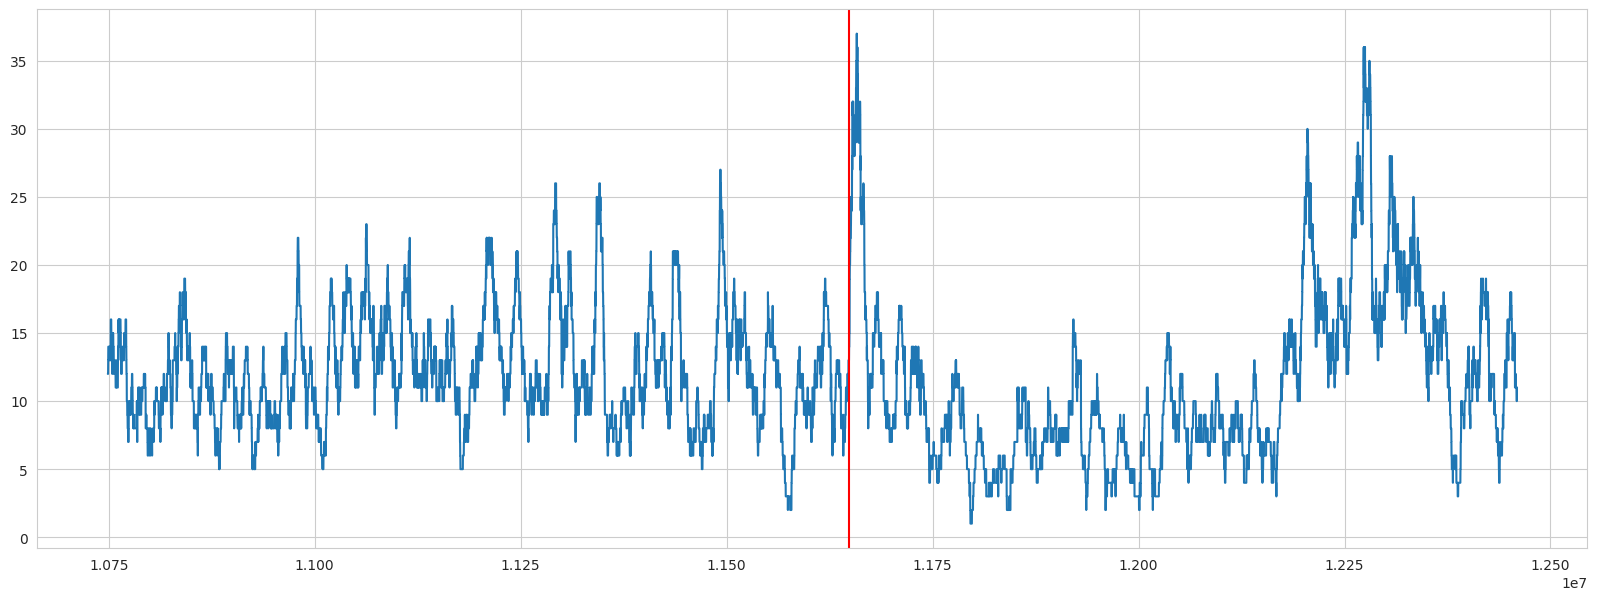

In [30]:
plt.figure(figsize=(20,7))
plt.plot(total_df['slot'], total_df['reorg_flag'].rolling(window=10000).sum())
plt.axvline(slot_pectra, color='r')

print(100*total_df[total_df['slot']<slot_pectra]['reorg_flag'].mean(), \
100*total_df[total_df['slot']>=slot_pectra]['reorg_flag'].mean())

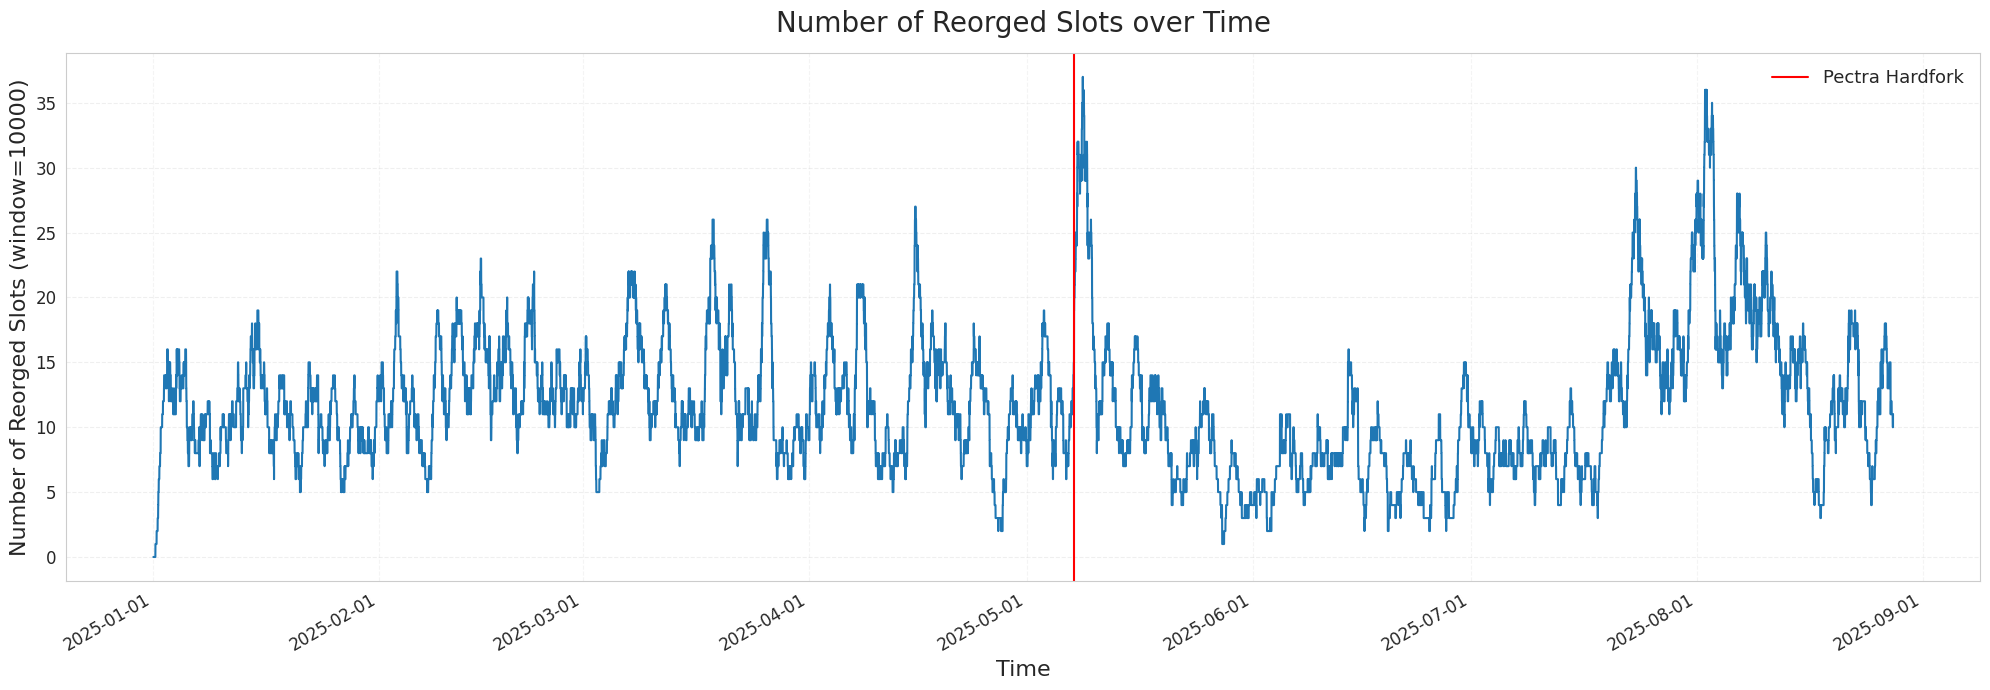

In [31]:
import matplotlib.dates as mdates

BASE_SLOT = 10738799
BASE_TIME = pd.Timestamp('2025-01-01 00:00:11')
SLOT_SECONDS = 12

total_df_copy = total_df.sort_values('slot').copy()
total_df_copy['slot_datetime'] = BASE_TIME + pd.to_timedelta((total_df_copy['slot'] - BASE_SLOT) * SLOT_SECONDS, unit='s')
pectra_datetime = BASE_TIME + pd.to_timedelta((slot_pectra - BASE_SLOT) * SLOT_SECONDS, unit='s')

plt.figure(figsize=(20, 7))
y_series = total_df_copy['reorg_flag'].rolling(window=10000, min_periods=1).sum()

plt.plot(total_df_copy['slot_datetime'], y_series, linewidth=1.5, color="tab:blue")

plt.axvline(pectra_datetime, color='r', linestyle='-', linewidth=1.5, label="Pectra Hardfork")


plt.xlabel('Time', fontsize=16)
plt.ylabel('Number of Reorged Slots (window=10000)', fontsize=16)
plt.title('Number of Reorged Slots over Time', fontsize=20, pad=15)

ax = plt.gca()
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gcf().autofmt_xdate()
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.grid(axis='x', linestyle='--', alpha=0.2)

plt.legend(loc="upper right", fontsize=13, frameon=False)

plt.tight_layout()
plt.show()

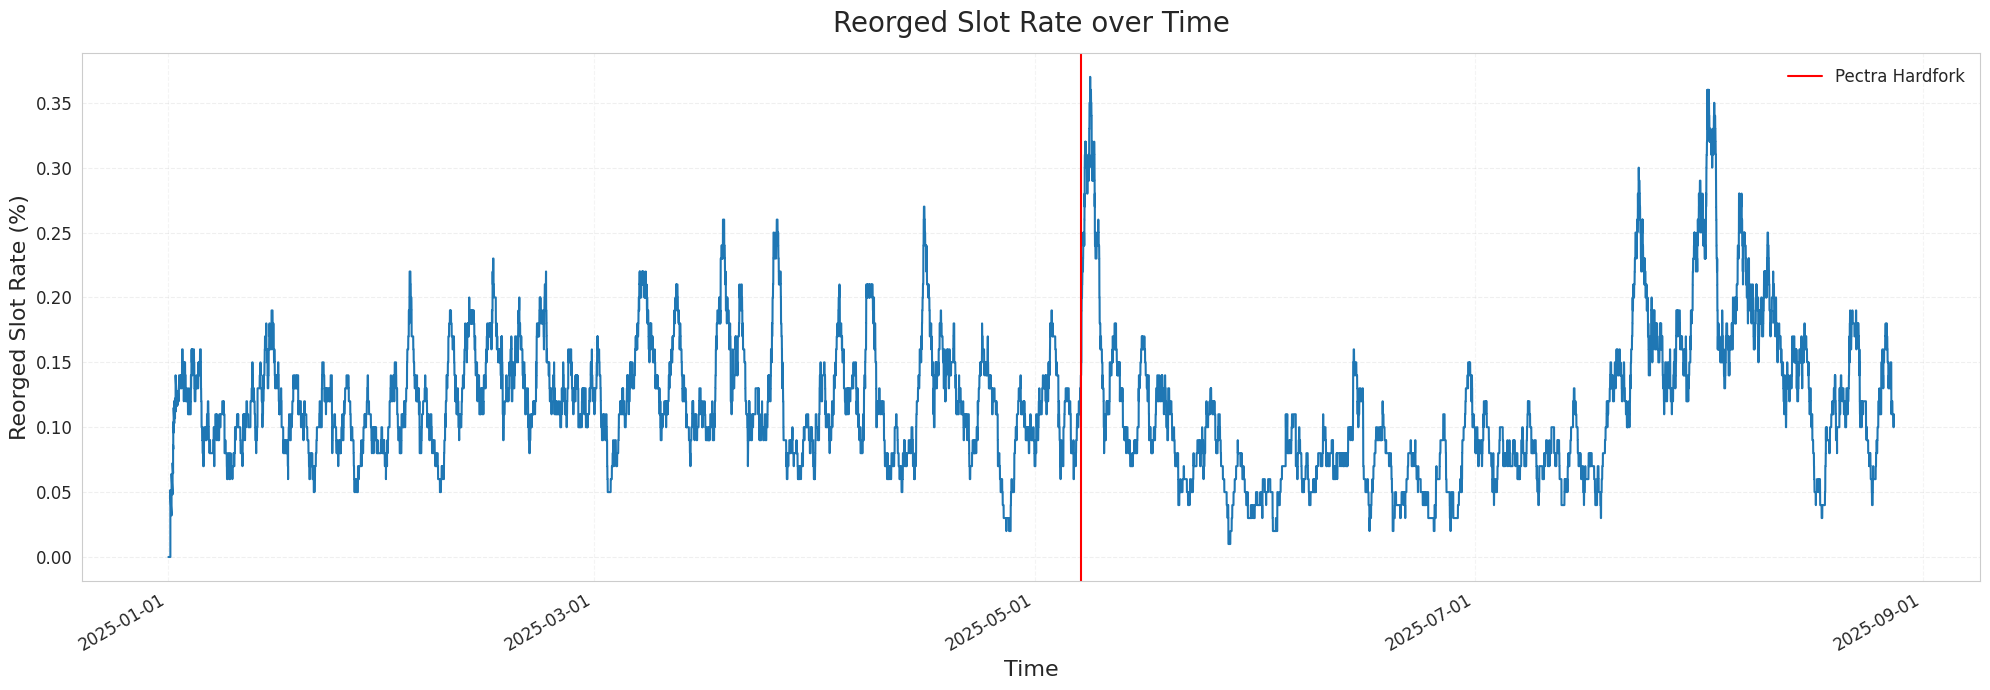

In [32]:
plt.figure(figsize=(20, 7))
y_series = total_df_copy['reorg_flag'].rolling(window=10000, min_periods=1).mean() * 100
plt.plot(total_df_copy['slot_datetime'], y_series, linewidth=1.5, color="tab:blue")
plt.axvline(pectra_datetime, color='r', linestyle='-', linewidth=1.5, label="Pectra Hardfork")

plt.xlabel('Time', fontsize=16)
plt.ylabel('Reorged Slot Rate (%)', fontsize=16)
plt.title('Reorged Slot Rate over Time', fontsize=20, pad=15)

ax = plt.gca()
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)
ax.xaxis.set_major_locator(mdates.AutoDateLocator(minticks=3, maxticks=6))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gcf().autofmt_xdate()

plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.grid(axis='x', linestyle='--', alpha=0.2)
plt.legend(loc="upper right", fontsize=12, frameon=False)

plt.tight_layout()
plt.show()

# max_prop

In [33]:
temp1['max_prop'].mean(), temp2['max_prop'].mean(), \
temp1['max_prop'].median(), temp2['max_prop'].median()

(np.float32(2148.77),
 np.float32(2052.486),
 np.float32(2014.0),
 np.float32(1888.0))

In [34]:
len(temp1[temp1['max_prop']>=3800]) * 100 / len(temp1), \
len(temp2[temp2['max_prop']>=3800]) * 100 / len(temp2)

(0.5942407077498387, 0.48277814054070156)

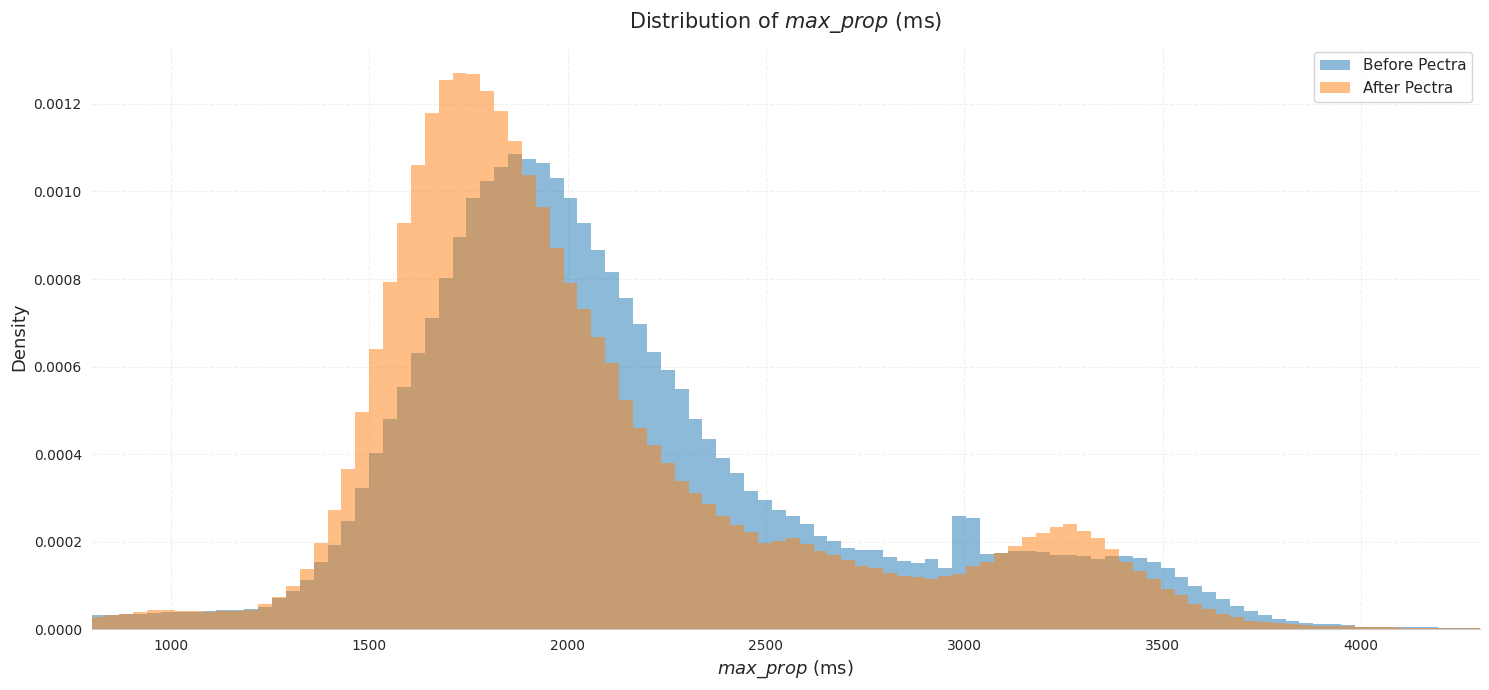

In [36]:
plt.figure(figsize=(15,7))
sns.set_style("whitegrid")

temp1['max_prop'].hist(range=(800, 4300), bins=100, density=True, alpha=0.5, edgecolor="none")
temp2['max_prop'].hist(range=(800, 4300), bins=100, density=True, alpha=0.5, edgecolor="none")

plt.xlim(800, 4300)
plt.xlabel('$\\it{max\_prop}$ (ms)', fontsize=13)
plt.ylabel('Density', fontsize=13)
plt.title('Distribution of $\\it{max\_prop}$ (ms)', fontsize=15, pad=12)
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.grid(axis='x', linestyle='--', alpha=0.3)
sns.despine(left=True, top=True, right=True)

plt.legend(['Before Pectra', 'After Pectra'], loc='upper right', fontsize=11)
plt.tight_layout()
plt.show()


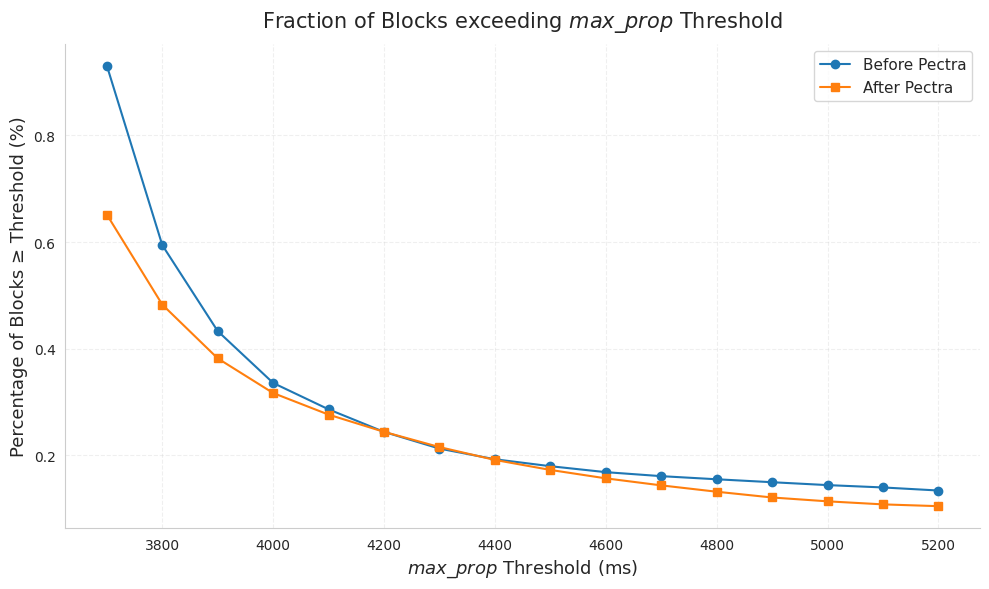

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

thresholds = np.arange(3700, 5300, 100)
counts_temp1 = [len(temp1[temp1['max_prop'] >= t]) for t in thresholds]
counts_temp2 = [len(temp2[temp2['max_prop'] >= t]) for t in thresholds]

counts_temp1_pct = np.array(counts_temp1) / len(temp1) * 100
counts_temp2_pct = np.array(counts_temp2) / len(temp2) * 100

plt.figure(figsize=(10,6))
sns.set_style("whitegrid")

plt.plot(thresholds, counts_temp1_pct, marker='o', linewidth=1.5, markersize=6, label='Before')
plt.plot(thresholds, counts_temp2_pct, marker='s', linewidth=1.5, markersize=6, label='After')

plt.xlabel('$\\it{max\\_prop}$ Threshold (ms)', fontsize=13)
plt.ylabel('Percentage of Blocks ≥ Threshold (%)', fontsize=13)
plt.title('Fraction of Blocks exceeding $\\it{max\\_prop}$ Threshold', fontsize=15, pad=12)

plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.grid(axis='x', linestyle='--', alpha=0.3)
sns.despine(left=False, bottom=False)

plt.legend(['Before Pectra', 'After Pectra'], loc='upper right', fontsize=11)
plt.tight_layout()
plt.show()

## Max blob prop, and block prop, one by one

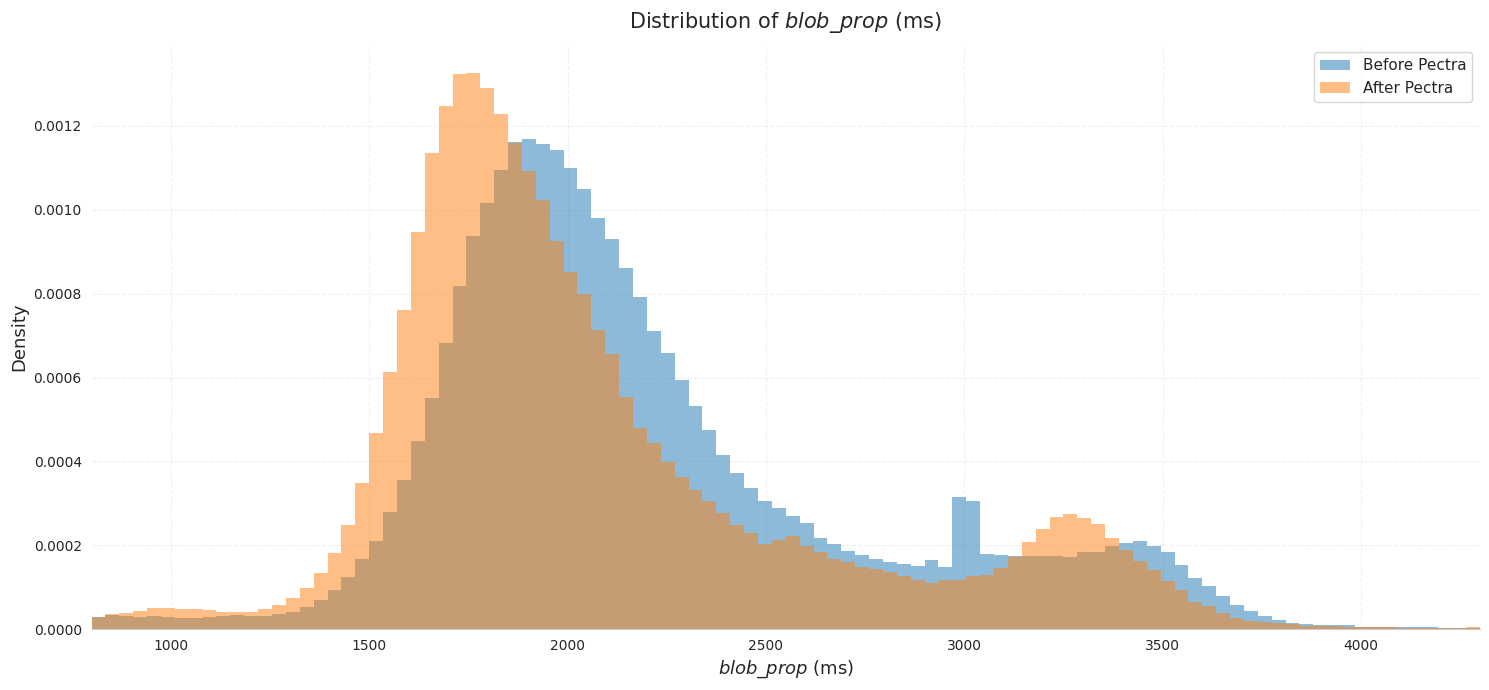

In [40]:
plt.figure(figsize=(15,7))
sns.set_style("whitegrid")

temp1['max_blob_prop'].hist(range=(800,4300),bins=100, density=True, alpha=0.5, edgecolor="none")
temp2['max_blob_prop'].hist(range=(800,4300),bins=100, density=True, alpha=0.5, edgecolor="none")

plt.xlim(800, 4300)
plt.xlabel('$\\it{blob\_prop}$ (ms)', fontsize=13)
plt.ylabel('Density', fontsize=13)
plt.title('Distribution of $\\it{blob\_prop}$ (ms)', fontsize=15, pad=12)
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.grid(axis='x', linestyle='--', alpha=0.3)
sns.despine(left=True, top=True, right=True)

plt.legend(['Before Pectra', 'After Pectra'], loc='upper right', fontsize=11)
plt.tight_layout()
plt.show()

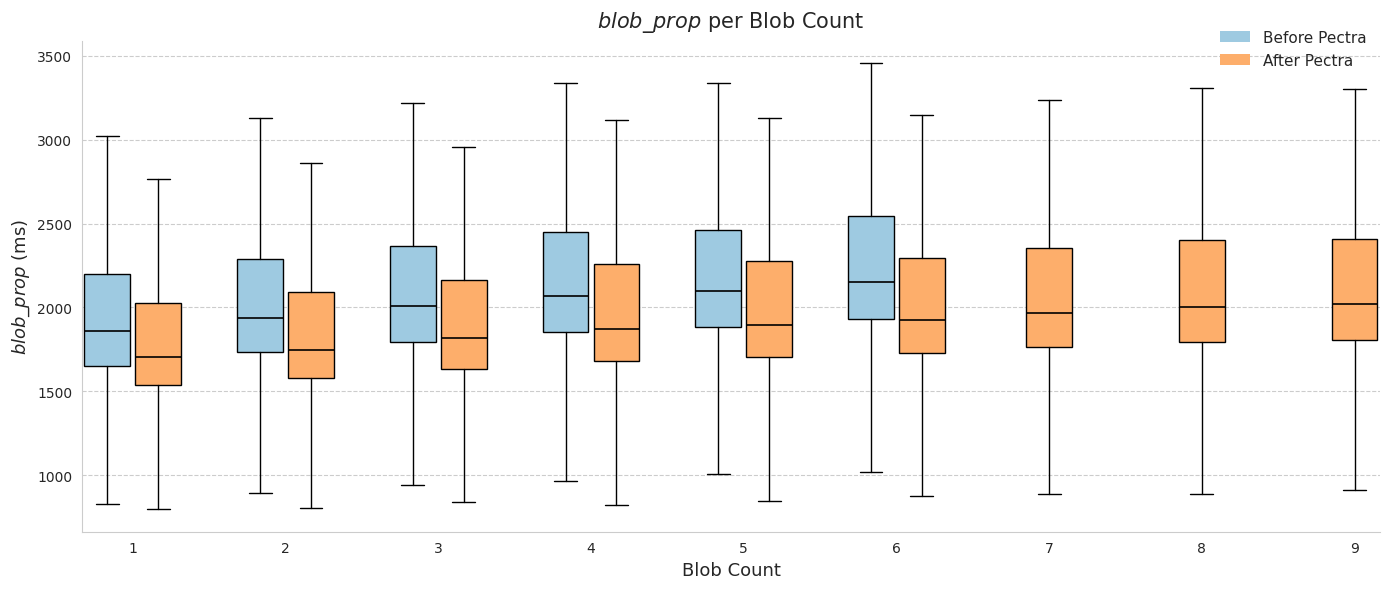

In [42]:
boxes_before = []
boxes_after = []
labels = []

for n in range(1, 10):
    df_before = total_df[(total_df['slot'] < slot_pectra) & (total_df['blob_count'] == n)]
    df_after  = total_df[(total_df['slot'] >= slot_pectra) & (total_df['blob_count'] == n)]
    if n <= 6:
        boxes_before.append(df_before['max_blob_prop'].dropna())
        boxes_after.append(df_after['max_blob_prop'].dropna())
    else:
        boxes_after.append(df_after['max_blob_prop'].dropna())
    labels.append(f'{n}')

plt.figure(figsize=(14,6))
sns.set_style("whitegrid")

pos_before = [i*3 - 0.5 for i in range(1,7)]
pos_after_first = [i*3 + 0.5 for i in range(1,7)]
pos_after_only = [i*3 for i in range(7,10)]

plt.boxplot(
    boxes_before,
    positions=pos_before,
    widths=0.9,
    patch_artist=True,
    showfliers=False,
    boxprops=dict(facecolor='#9ecae1', edgecolor='black'),
    medianprops=dict(color='black', linewidth=1.2),
    whiskerprops=dict(color='black'),
    capprops=dict(color='black')
)

plt.boxplot(
    boxes_after,
    positions=pos_after_first + pos_after_only,
    widths=0.9,
    patch_artist=True,
    showfliers=False,
    boxprops=dict(facecolor='#fdae6b', edgecolor='black'),
    medianprops=dict(color='black', linewidth=1.2),
    whiskerprops=dict(color='black'),
    capprops=dict(color='black')
)

plt.xticks([i*3 for i in range(1,10)], labels, rotation=0)
plt.xlabel('Blob Count', fontsize=13)
plt.ylabel('$\\it{blob\\_prop}$ (ms)', fontsize=13)
plt.title('$\\it{blob\\_prop}$ per Blob Count', fontsize=15, pad=10)

plt.grid(axis='y', linestyle='--')
plt.grid(axis='x', visible=False)

sns.despine(left=False, bottom=False)

legend_handles = [
    mpatches.Patch(facecolor='#9ecae1', edgecolor='none', label='Before Pectra'),
    mpatches.Patch(facecolor='#fdae6b', edgecolor='none', label='After Pectra')
]
plt.legend(
    handles=legend_handles,
    loc='upper right',
    bbox_to_anchor=(1, 1.05),
    fontsize=11,
    frameon=False
)
plt.tight_layout()
plt.show()

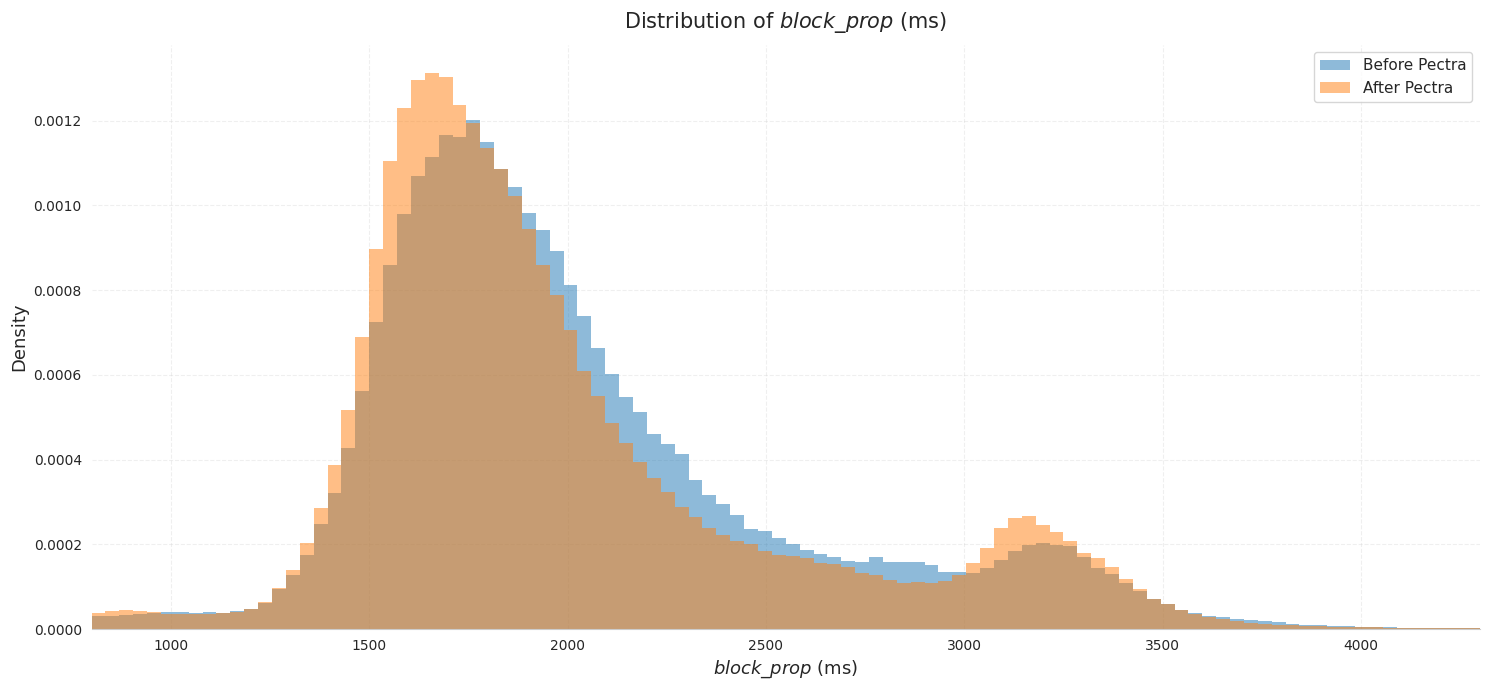

In [44]:
plt.figure(figsize=(15,7))
sns.set_style("whitegrid")

temp1['block_prop_libp2p'].hist(range=(800,4300),bins=100, density=True, alpha=0.5, edgecolor='none')
temp2['block_prop_libp2p'].hist(range=(800,4300),bins=100, density=True, alpha=0.5, edgecolor='none')
plt.xlim(800, 4300)
plt.xlabel('$\\it{block\_prop}$ (ms)', fontsize=13)
plt.ylabel('Density', fontsize=13)
plt.title('Distribution of $\\it{block\_prop}$ (ms)', fontsize=15, pad=12)
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.grid(axis='x', linestyle='--', alpha=0.3)
sns.despine(left=True, top=True, right=True)

plt.legend(['Before Pectra', 'After Pectra'], loc='upper right', fontsize=11)
plt.tight_layout()
plt.show()

## blob_prop being bottleneck ?

In [45]:
100*len(temp1[(temp1['max_prop'] != temp1['block_prop_libp2p']) & (temp1['blob_count']!=0)]) / len(temp1[temp1['blob_count']!=0]), \
100*len(temp2[(temp2['max_prop'] != temp2['block_prop_libp2p']) & (temp2['blob_count']!=0)]) / len(temp2[temp2['blob_count']!=0]),


(85.19062543855546, 74.89985602944172)

/tmp/ipykernel_78285/976639592.py:2: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby('blob_count').apply(lambda g: (g['max_blob_prop'] > g['block_prop_libp2p']).mean())
/tmp/ipykernel_78285/976639592.py:2: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby('blob_count').apply(lambda g: (g['max_blob_prop'] > g['block_prop_libp2p']).mean())


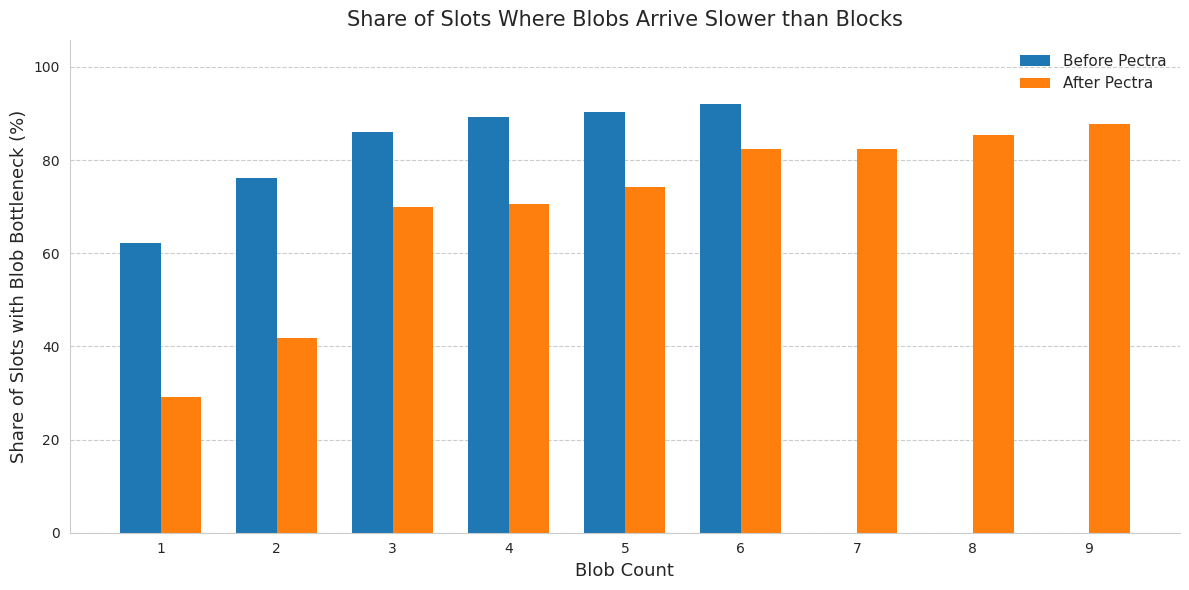

In [47]:
def compute_ratio(df):
    return df.groupby('blob_count').apply(lambda g: (g['max_blob_prop'] > g['block_prop_libp2p']).mean())

ratio_before = compute_ratio(temp1)
ratio_after  = compute_ratio(temp2)

all_blob_counts = sorted(set(ratio_before.index) | set(ratio_after.index))[1:]
ratio_before = ratio_before.reindex(all_blob_counts, fill_value=0)
ratio_after  = ratio_after.reindex(all_blob_counts, fill_value=0)

before_pct = (ratio_before.values * 100)
after_pct  = (ratio_after.values * 100)

x = np.arange(len(all_blob_counts))
width = 0.35

plt.figure(figsize=(12,6))
sns.set_style("whitegrid")

plt.bar(x - width/2, before_pct, width, label='Before Pectra', edgecolor='none')
plt.bar(x + width/2, after_pct,  width, label='After Pectra',  edgecolor='none')

plt.xlabel('Blob Count', fontsize=13)
plt.ylabel('Share of Slots with Blob Bottleneck (%)', fontsize=13)  # max_blob_prop > block_prop_libp2p
plt.title('Share of Slots Where Blobs Arrive Slower than Blocks', fontsize=15, pad=10)

plt.xticks(x, [int(c) for c in all_blob_counts])
plt.ylim(0, max(before_pct.max(), after_pct.max()) * 1.15)

plt.grid(axis='y', linestyle='--')
plt.grid(axis='x', visible=False)
sns.despine(left=False, bottom=False)

plt.legend(fontsize=11, loc='upper right', frameon=False)
plt.tight_layout()
plt.show()

/tmp/ipykernel_78285/1599758769.py:14: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = plt.boxplot(


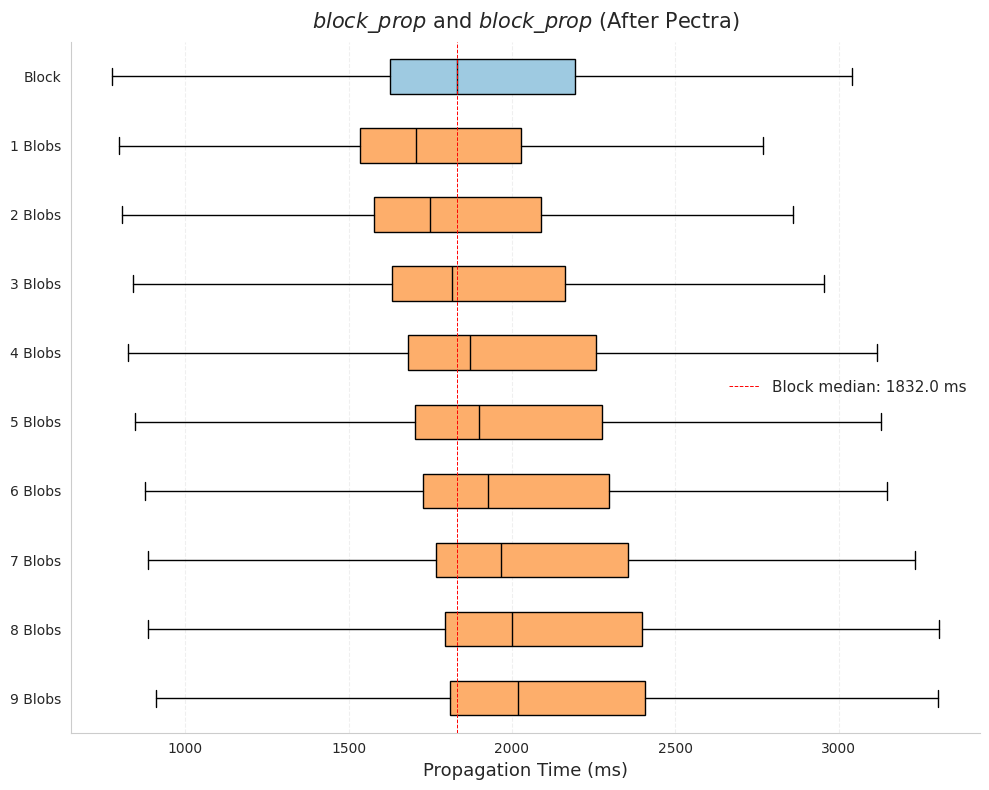

In [49]:
boxes = []
for n in range(9, 0, -1):
    df_n = total_df[(total_df['slot'] >= slot_pectra) & (total_df['blob_count'] == n)]
    boxes.append(df_n['max_blob_prop'].dropna() if not df_n.empty else pd.Series(dtype=float))
boxes.append(total_df[total_df['slot'] >= slot_pectra]['block_prop_libp2p'].dropna())

labels = [f'{i} Blobs' for i in range(9, 0, -1)] + ['Block']

plt.figure(figsize=(10,8))
sns.set_style("whitegrid")

colors = ['#fdae6b']*9 + ['#9ecae1'] 

bp = plt.boxplot(
    boxes,
    labels=labels,
    showfliers=False,
    vert=False,
    patch_artist=True,
)

for i, (patch, color) in enumerate(zip(bp['boxes'], colors)):
    patch.set_facecolor(color)
    patch.set_edgecolor("black")

    bp['medians'][i].set_color("black")
    bp['medians'][i].set_linewidth(1.0)

    bp['whiskers'][2*i].set_color("black")
    bp['whiskers'][2*i+1].set_color("black")
    bp['whiskers'][2*i].set_linewidth(1.0)
    bp['whiskers'][2*i+1].set_linewidth(1.0)

    bp['caps'][2*i].set_color("black")
    bp['caps'][2*i+1].set_color("black")
    bp['caps'][2*i].set_linewidth(1.0)
    bp['caps'][2*i+1].set_linewidth(1.0)

# Block median 라인
block_median = boxes[-1].median()
plt.axvline(block_median, color='red', linestyle='--', linewidth=0.7, zorder=10, 
            label=f'Block median: {block_median:.1f} ms')

plt.xlabel('Propagation Time (ms)', fontsize=13)
plt.title('$\\it{block\_prop}$ and $\\it{block\_prop}$ (After Pectra)', fontsize=15, pad=10)

plt.grid(axis='x', linestyle='--', alpha=0.3)
plt.grid(axis='y', visible=False)
sns.despine(left=False, bottom=False)

plt.legend(loc='center right', fontsize=11, frameon=False)
plt.tight_layout()
plt.show()

/tmp/ipykernel_78285/1233871868.py:15: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = plt.boxplot(


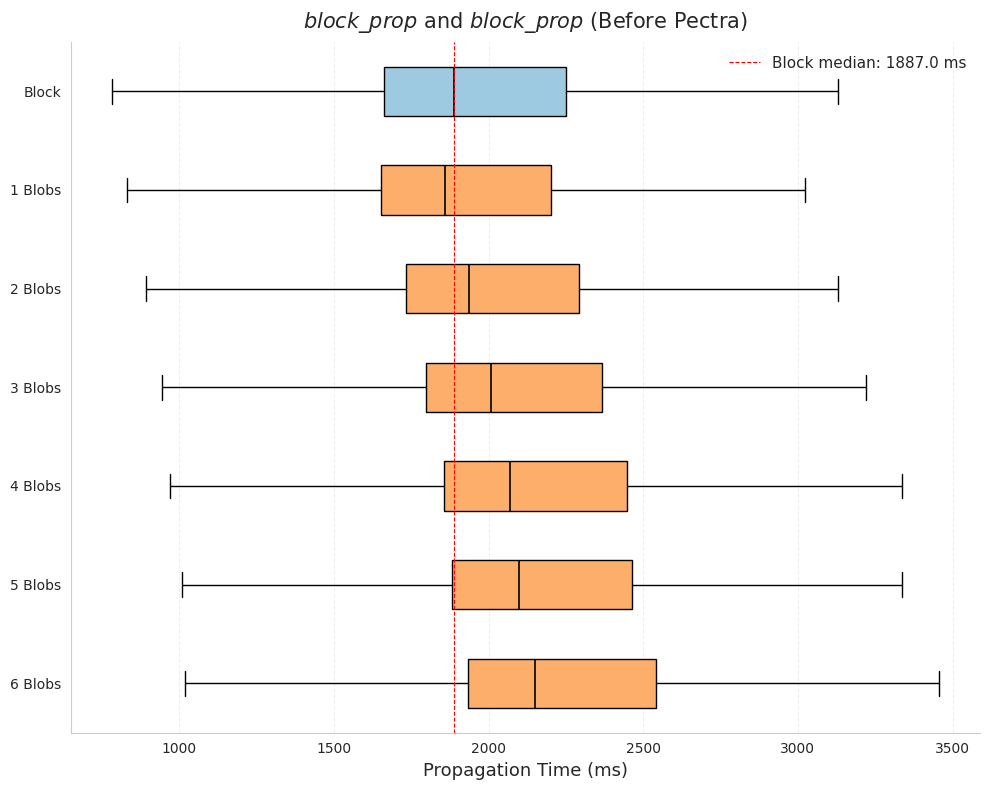

In [51]:
boxes = []
for n in range(6, 0, -1):
    df_n = total_df[(total_df['slot'] < slot_pectra) & (total_df['blob_count'] == n)]
    boxes.append(df_n['max_blob_prop'].dropna() if not df_n.empty else pd.Series(dtype=float))

boxes.append(total_df[total_df['slot'] < slot_pectra]['block_prop_libp2p'].dropna())

labels = [f'{i} Blobs' for i in range(6, 0, -1)] + ['Block']

plt.figure(figsize=(10,8))
sns.set_style("whitegrid")

colors = ['#fdae6b']*6 + ['#9ecae1']

bp = plt.boxplot(
    boxes,
    labels=labels,
    showfliers=False,
    vert=False,
    patch_artist=True,
)

for i, (patch, color) in enumerate(zip(bp['boxes'], colors)):
    patch.set_facecolor(color)
    patch.set_edgecolor("black")

    bp['medians'][i].set_color("black")
    bp['medians'][i].set_linewidth(1.2)

    bp['whiskers'][2*i].set_color("black")
    bp['whiskers'][2*i+1].set_color("black")
    bp['whiskers'][2*i].set_linewidth(1.0)
    bp['whiskers'][2*i+1].set_linewidth(1.0)

    bp['caps'][2*i].set_color("black")
    bp['caps'][2*i+1].set_color("black")
    bp['caps'][2*i].set_linewidth(1.0)
    bp['caps'][2*i+1].set_linewidth(1.0)

block_median = boxes[-1].median()
plt.axvline(
    block_median,
    color='red', linestyle='--', linewidth=0.8,
    zorder=10, label=f'Block median: {block_median:.1f} ms'
)

plt.xlabel('Propagation Time (ms)', fontsize=13)
plt.title('$\\it{block\_prop}$ and $\\it{block\_prop}$ (Before Pectra)', fontsize=15, pad=10)

plt.grid(axis='x', linestyle='--', alpha=0.3)
plt.grid(axis='y', visible=False)
sns.despine(left=False, bottom=False)

plt.legend(loc='upper right', fontsize=11, frameon=False)
plt.tight_layout()
plt.show()

# Block size

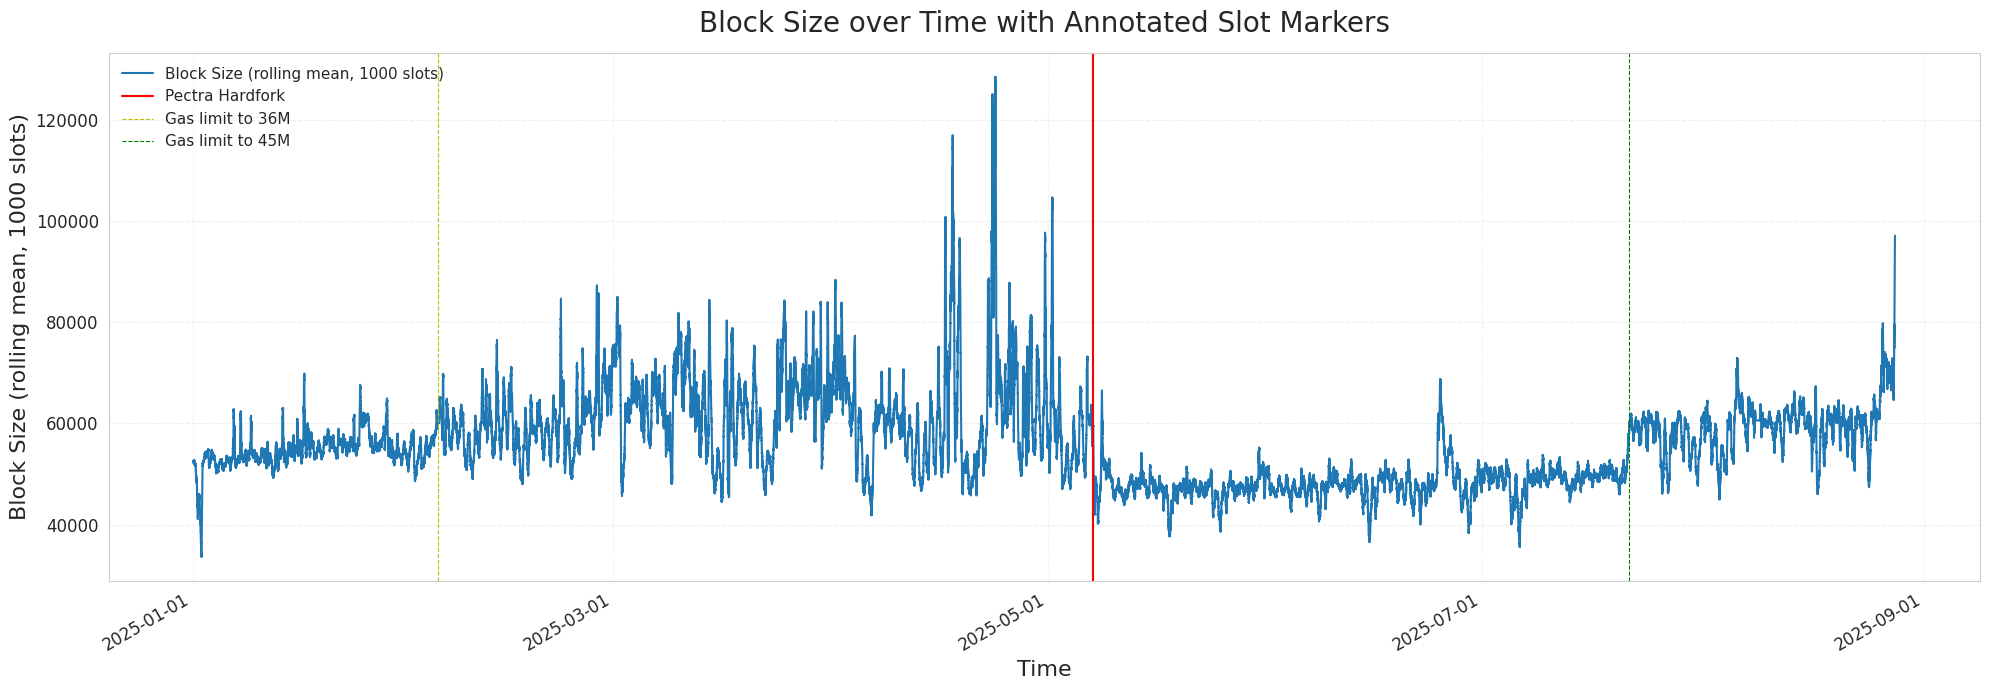

In [53]:
BASE_SLOT = 10738799
BASE_TIME = pd.Timestamp('2025-01-01 00:00:11')
SLOT_SECONDS = 12

def slot_to_dt(slot):
    return BASE_TIME + pd.to_timedelta((slot - BASE_SLOT) * SLOT_SECONDS, unit='s')

plot_df = total_df.dropna(subset=['block_size']).sort_values('slot').copy()
plot_df['slot_datetime'] = slot_to_dt(plot_df['slot'])

pectra_dt   = slot_to_dt(slot_pectra)
end36m_dt   = slot_to_dt(slot_36m_end)
end45m_dt   = slot_to_dt(slot_45m_end)

roll = plot_df['block_size'].rolling(window=1000, min_periods=1000).mean()
mask = roll.notna()

plt.figure(figsize=(20,7))
plt.plot(plot_df.loc[mask, 'slot_datetime'], roll[mask], linewidth=1.5, label='Block Size (rolling mean, 1000 slots)')
plt.axvline(pectra_dt, color='r',  linestyle='-',  linewidth=1.5, label="Pectra Hardfork")
plt.axvline(end36m_dt, color='y',  linestyle='--', linewidth=0.8, label="Gas limit to 36M")
plt.axvline(end45m_dt, color='g',  linestyle='--', linewidth=0.8, label="Gas limit to 45M")
plt.xlabel("Time", fontsize=16)
plt.ylabel("Block Size (rolling mean, 1000 slots)", fontsize=16)
plt.title("Block Size over Time with Annotated Slot Markers", fontsize=20, pad=15)
ax = plt.gca()
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)
ax.xaxis.set_major_locator(mdates.AutoDateLocator(minticks=3, maxticks=6))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gcf().autofmt_xdate()
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.grid(axis='x', linestyle='--', alpha=0.2)
plt.legend(loc="upper left", fontsize=11, frameon=False)
plt.tight_layout()
plt.show()

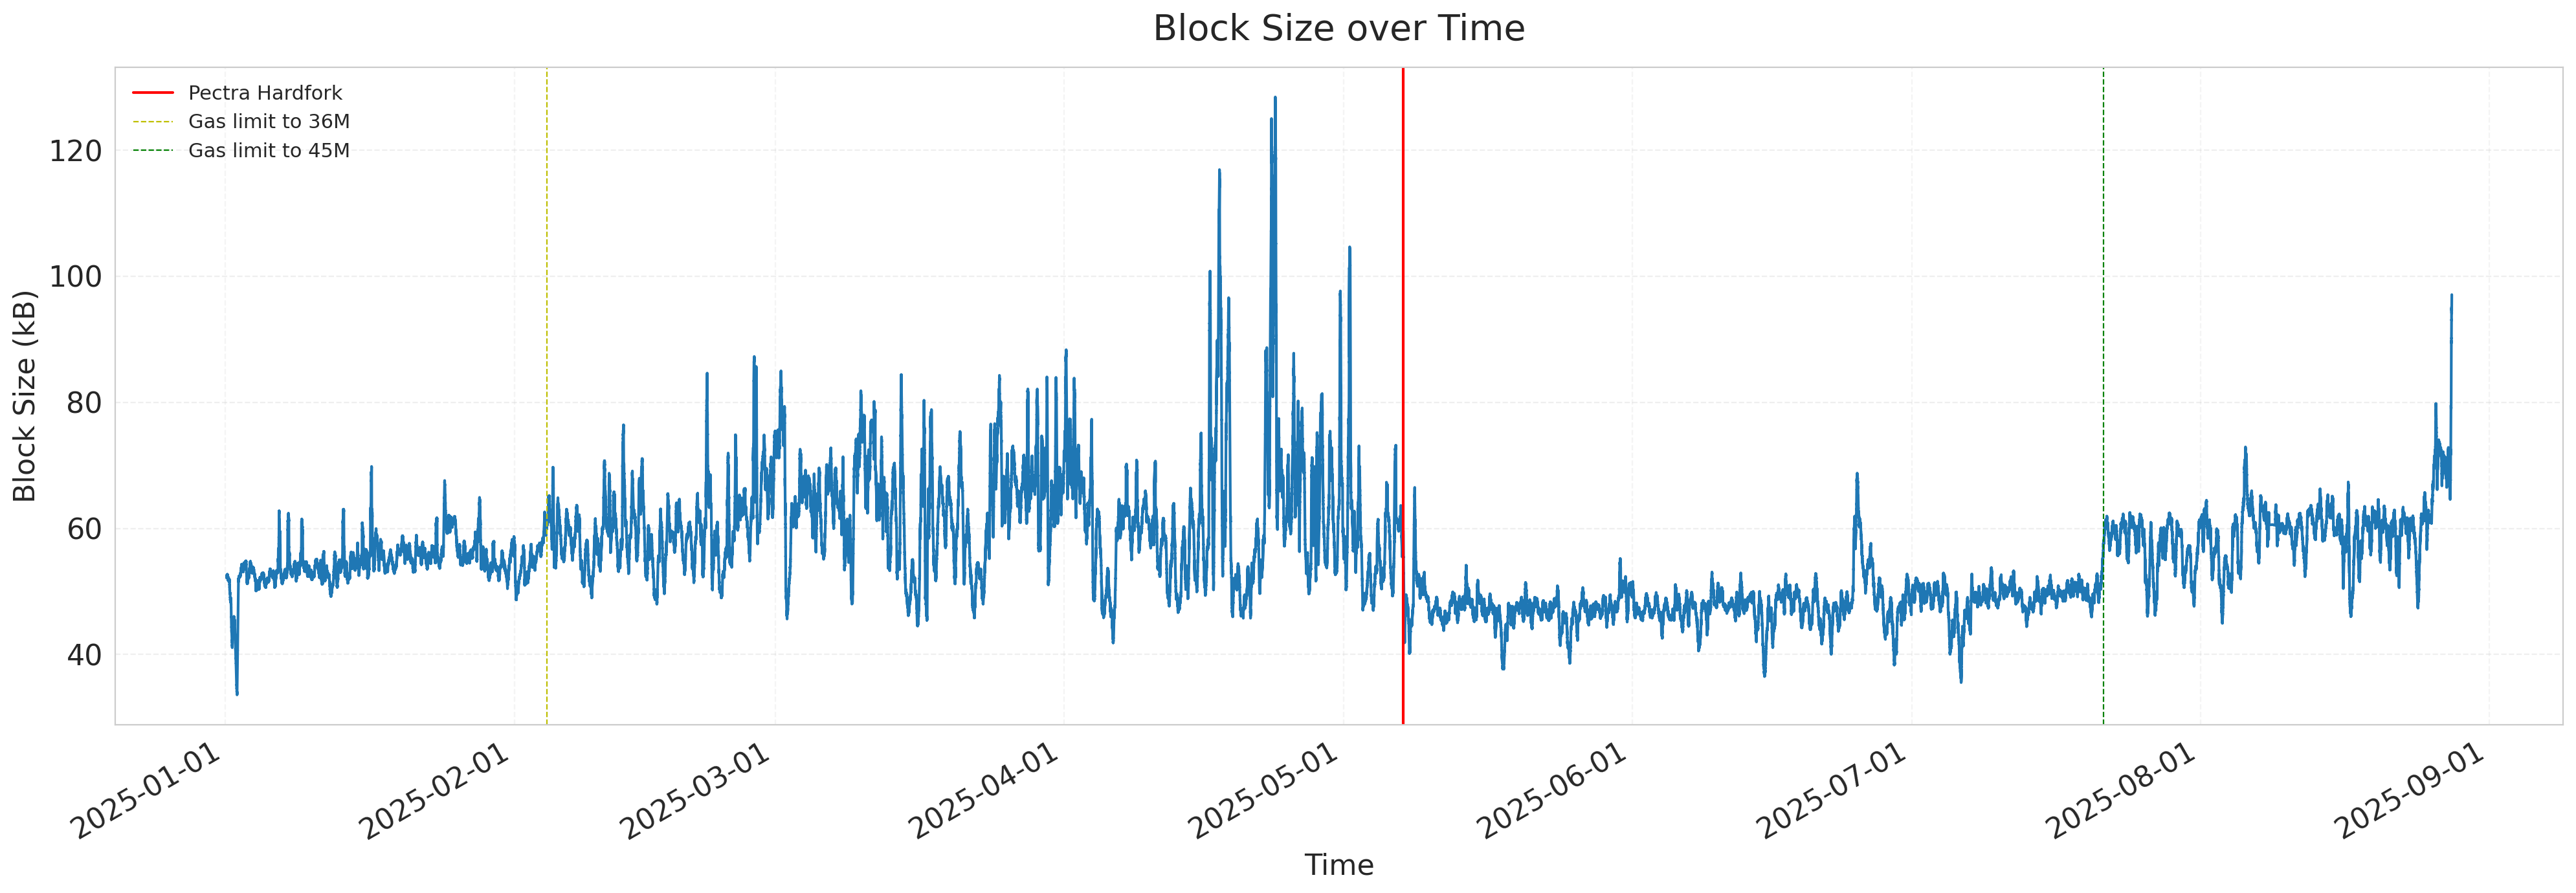

In [54]:
plt.figure(figsize=(20,7),dpi=200)

line, = plt.plot(
    plot_df.loc[mask, 'slot_datetime'],
    roll[mask],
    linewidth=1.5,
    label='_nolegend_'
)

h_pectra = plt.axvline(pectra_dt, color='r', linestyle='-',  linewidth=1.5, label="Pectra Hardfork")
h_36m    = plt.axvline(end36m_dt, color='y', linestyle='--', linewidth=0.8, label="Gas limit to 36M")
h_45m    = plt.axvline(end45m_dt, color='g', linestyle='--', linewidth=0.8, label="Gas limit to 45M")

plt.xlabel("Time", fontsize=16)
plt.ylabel("Block Size (kB)", fontsize=16)
plt.title("Block Size over Time", fontsize=20, pad=15)

ax = plt.gca()

ax = plt.gca()
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)
ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"{x/1000:.0f}"))

ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gcf().autofmt_xdate()
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.grid(axis='x', linestyle='--', alpha=0.2)

plt.legend(handles=[h_pectra, h_36m, h_45m], loc="upper left", fontsize=11, frameon=False)
plt.tight_layout()
plt.show()

In [55]:
df_sizes = client.query_df(f"""
    SELECT
        slot,
        block_total_bytes_compressed AS block_size,
        execution_payload_transactions_total_bytes_compressed AS execution_size,
        (block_total_bytes_compressed - execution_payload_transactions_total_bytes_compressed) AS consensus_size
    FROM default.beacon_api_eth_v2_beacon_block
    WHERE slot BETWEEN {slot_36m_end} AND {slot_45m_start - 1}
      AND block_total_bytes_compressed IS NOT NULL
""")

# Optional: sort, set index for later time-series ops
df_sizes = df_sizes.sort_values("slot").reset_index(drop=True)
print(df_sizes.head(), len(df_sizes))

       slot  block_size  execution_size  consensus_size
0  10987142       71515           52124           19391
1  10987143       59700           34163           25537
2  10987144       77839           58057           19782
3  10987145       62970           44140           18830
4  10987146       43856           31507           12349 1601873


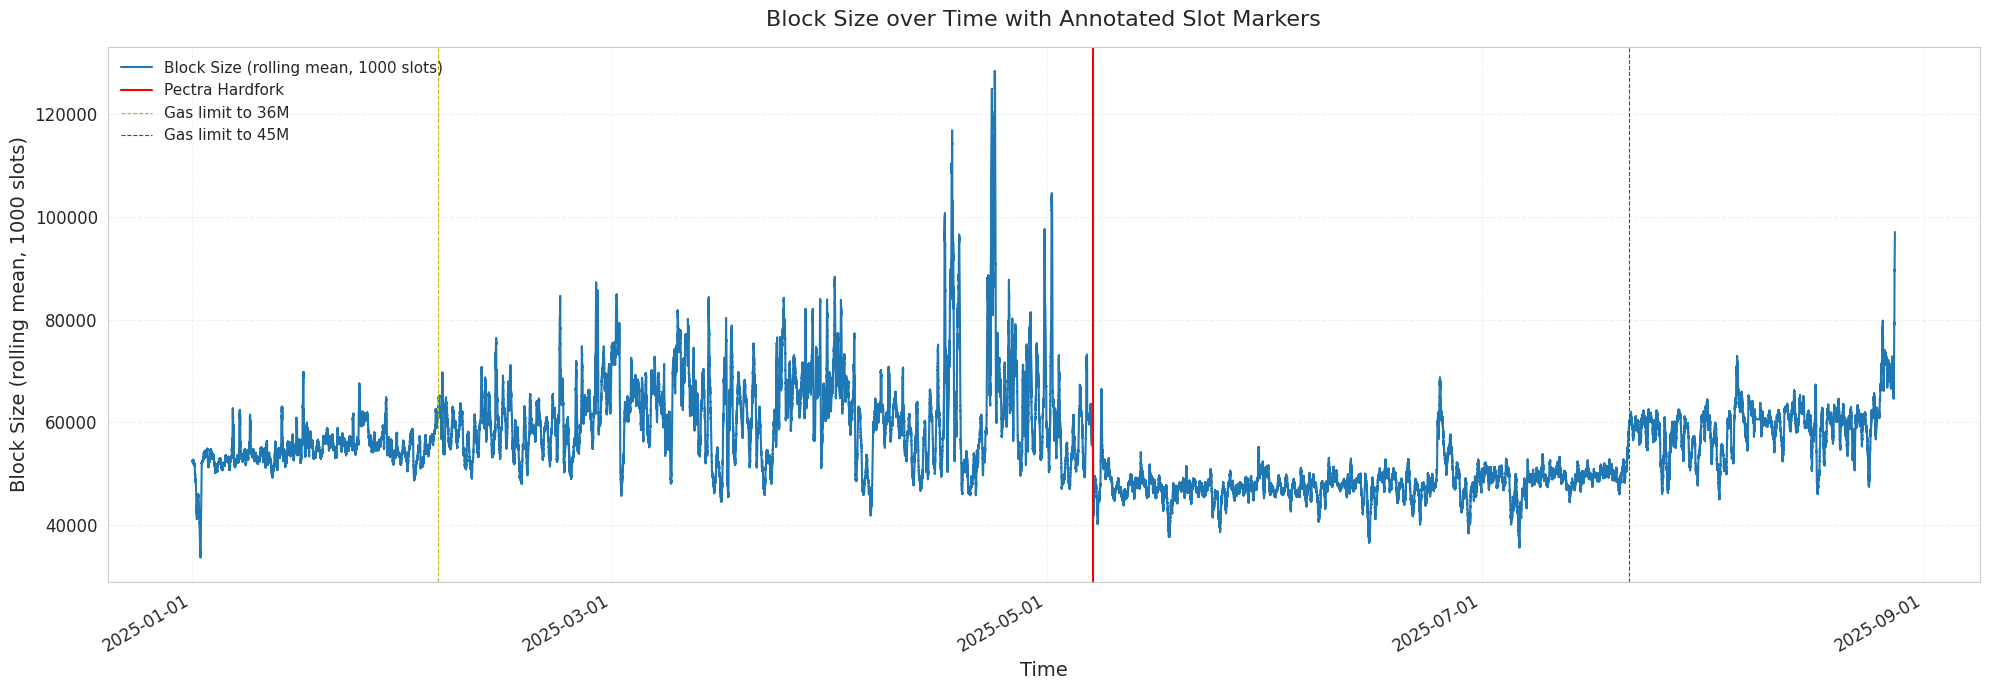

In [56]:
BASE_SLOT = 10738799
BASE_TIME = pd.Timestamp('2025-01-01 00:00:11')
SLOT_SECONDS = 12

def slot_to_dt(slot):
    return BASE_TIME + pd.to_timedelta((slot - BASE_SLOT) * SLOT_SECONDS, unit='s')

plot_df = total_df.dropna(subset=['block_size']).sort_values('slot').copy()
plot_df['slot_datetime'] = slot_to_dt(plot_df['slot'])

pectra_dt   = slot_to_dt(slot_pectra)
end36m_dt   = slot_to_dt(slot_36m_end)
end45m_dt   = slot_to_dt(slot_45m_end)

roll = plot_df['block_size'].rolling(window=1000, min_periods=1000).mean()
mask = roll.notna()

plt.figure(figsize=(20,7))
plt.plot(plot_df.loc[mask, 'slot_datetime'], roll[mask], linewidth=1.5, label='Block Size (rolling mean, 1000 slots)')
plt.axvline(pectra_dt, color='r',  linestyle='-',  linewidth=1.5, label="Pectra Hardfork")
plt.axvline(end36m_dt, color='y',  linestyle='--', linewidth=0.8, label="Gas limit to 36M")
plt.axvline(end45m_dt, color='g',  linestyle='--', linewidth=0.8, label="Gas limit to 45M")
plt.xlabel("Time", fontsize=14)
plt.ylabel("Block Size (rolling mean, 1000 slots)", fontsize=14)
plt.title("Block Size over Time with Annotated Slot Markers", fontsize=16, pad=15)
ax = plt.gca()
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)
ax.xaxis.set_major_locator(mdates.AutoDateLocator(minticks=3, maxticks=6))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gcf().autofmt_xdate()
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.grid(axis='x', linestyle='--', alpha=0.2)
plt.legend(loc="upper left", fontsize=11, frameon=False)
plt.tight_layout()
plt.show()

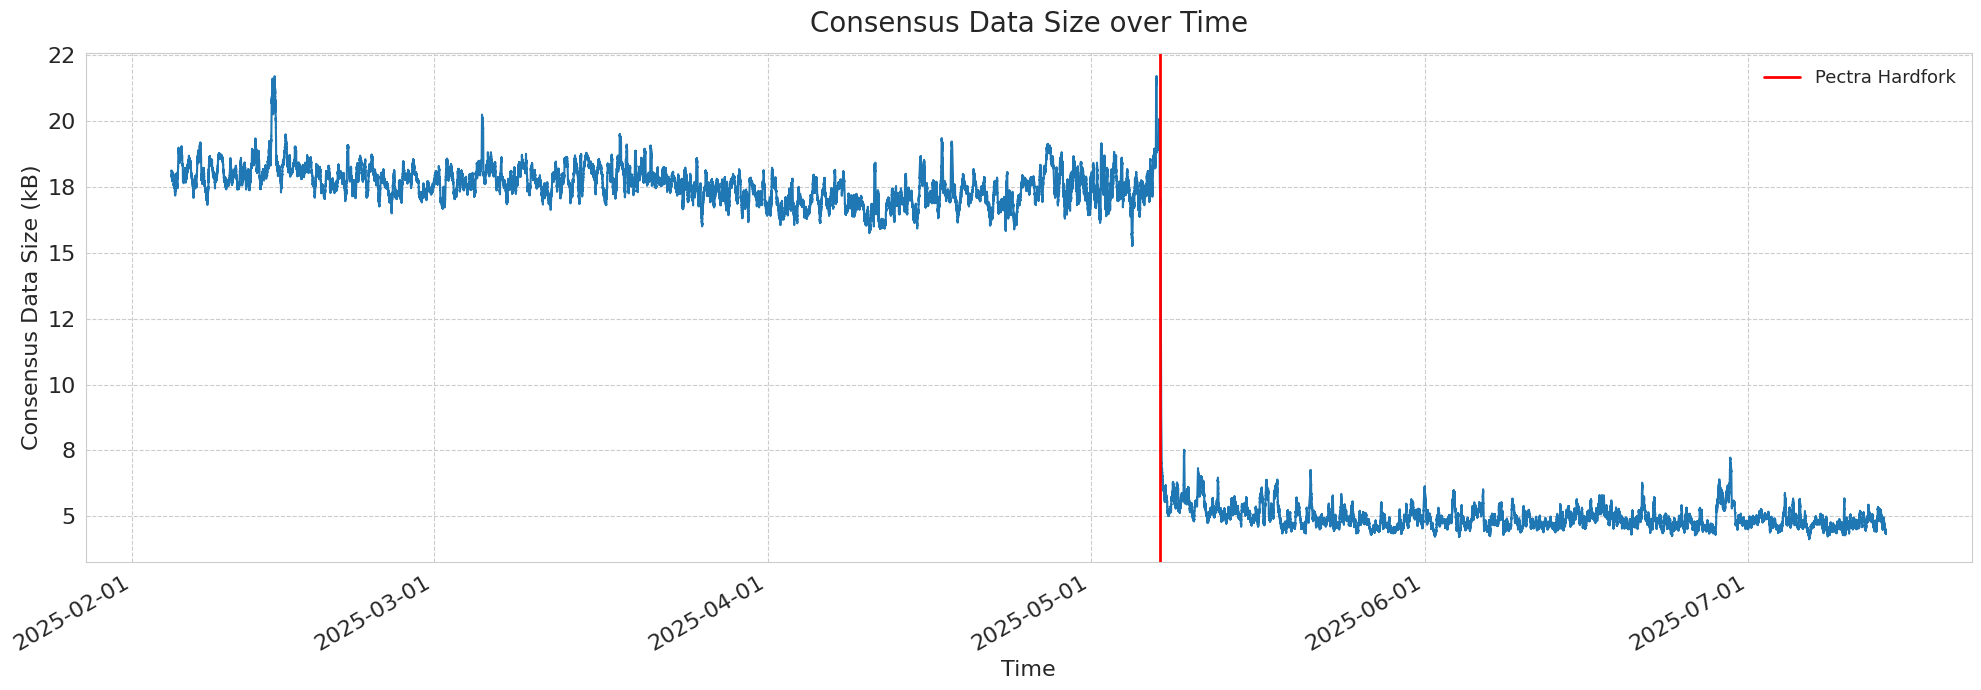

In [57]:
import matplotlib.dates as mdates

BASE_SLOT = 10738799
BASE_TIME = pd.Timestamp('2025-01-01 00:00:11')
SLOT_SECONDS = 12

def slot_to_dt(slot):
    return BASE_TIME + pd.to_timedelta((slot - BASE_SLOT) * SLOT_SECONDS, unit='s')

df_sizes_copy = df_sizes.sort_values('slot').copy()
df_sizes_copy['slot_datetime'] = slot_to_dt(df_sizes_copy['slot'])
pectra_dt = slot_to_dt(slot_pectra)
roll = df_sizes_copy['consensus_size'].rolling(window=1000, min_periods=1000).mean()
mask = roll.notna()
plt.figure(figsize=(20,7))
plt.plot(df_sizes_copy.loc[mask, 'slot_datetime'], roll[mask], linewidth=1.5, color="tab:blue")
plt.axvline(pectra_dt, color='r', linewidth=2, label="Pectra Hardfork")

plt.title("Consensus Data Size over Time", fontsize=20, pad=15)
plt.xlabel("Time", fontsize=16)
plt.ylabel("Consensus Data Size (kB)", fontsize=16)

ax = plt.gca()
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)
ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"{x/1000:.0f}"))

ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gcf().autofmt_xdate()

plt.grid(axis='y', linestyle='--')
plt.grid(axis='x', linestyle='--')

plt.legend(loc="upper right", fontsize=13, frameon=False)
plt.tight_layout()
plt.show()

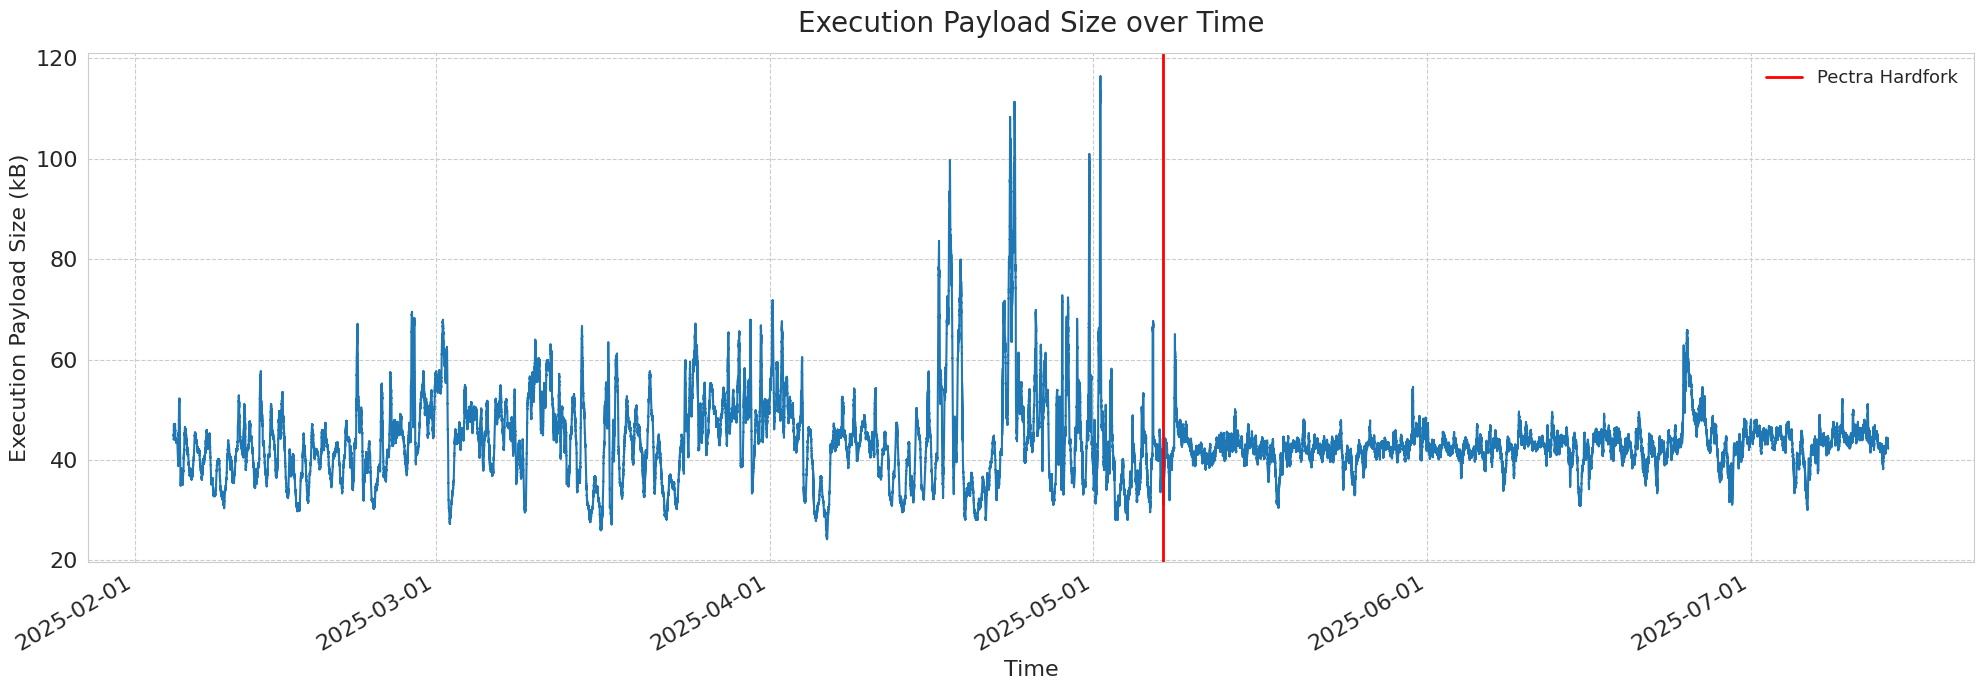

In [58]:
import matplotlib.dates as mdates

BASE_SLOT = 10738799
BASE_TIME = pd.Timestamp('2025-01-01 00:00:11')
SLOT_SECONDS = 12

def slot_to_dt(slot):
    return BASE_TIME + pd.to_timedelta((slot - BASE_SLOT) * SLOT_SECONDS, unit='s')

df_sizes_copy = df_sizes.sort_values('slot').copy()
df_sizes_copy['slot_datetime'] = slot_to_dt(df_sizes_copy['slot'])
pectra_dt = slot_to_dt(slot_pectra)
roll = df_sizes_copy['execution_size'].rolling(window=1000, min_periods=1000).mean()
mask = roll.notna()

plt.figure(figsize=(20,7))
plt.plot(df_sizes_copy.loc[mask, 'slot_datetime'], roll[mask], linewidth=1.5, color="tab:blue")
plt.axvline(pectra_dt, color='r', linewidth=2, label="Pectra Hardfork")
plt.title("Execution Payload Size over Time", fontsize=20, pad=15)
plt.xlabel("Time", fontsize=16)
plt.ylabel("Execution Payload Size (kB)", fontsize=16)

ax = plt.gca()
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)
ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"{x/1000:.0f}"))
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gcf().autofmt_xdate()

plt.grid(axis='y', linestyle='--')
plt.grid(axis='x', linestyle='--')

plt.legend(loc="upper right", fontsize=13, frameon=False)
plt.tight_layout()
plt.show()

In [59]:
df_sizes[df_sizes['slot']<slot_pectra]['execution_size'].mean(), df_sizes[df_sizes['slot']<slot_pectra]['execution_size'].std(), \
df_sizes[df_sizes['slot']>=slot_pectra]['execution_size'].mean(), df_sizes[df_sizes['slot']>=slot_pectra]['execution_size'].std(),\
df_sizes[df_sizes['slot']<slot_pectra]['consensus_size'].mean(), df_sizes[df_sizes['slot']<slot_pectra]['consensus_size'].std(), \
df_sizes[df_sizes['slot']>=slot_pectra]['consensus_size'].mean(), df_sizes[df_sizes['slot']>=slot_pectra]['consensus_size'].std(),\
df_sizes[df_sizes['slot']<slot_pectra]['block_size'].mean(), df_sizes[df_sizes['slot']<slot_pectra]['block_size'].std(), \
df_sizes[df_sizes['slot']>=slot_pectra]['block_size'].mean(), df_sizes[df_sizes['slot']>=slot_pectra]['block_size'].std(),\



(np.float64(44136.710449898674),
 np.float64(31735.001441293196),
 np.float64(42839.38067616305),
 np.float64(18637.912353590407),
 np.float64(17603.080348516713),
 np.float64(4123.201563208685),
 np.float64(4965.910631822601),
 np.float64(2287.619167218286),
 np.float64(61739.790798415386),
 np.float64(32039.822667804463),
 np.float64(47805.291307985644),
 np.float64(18945.990355941994))

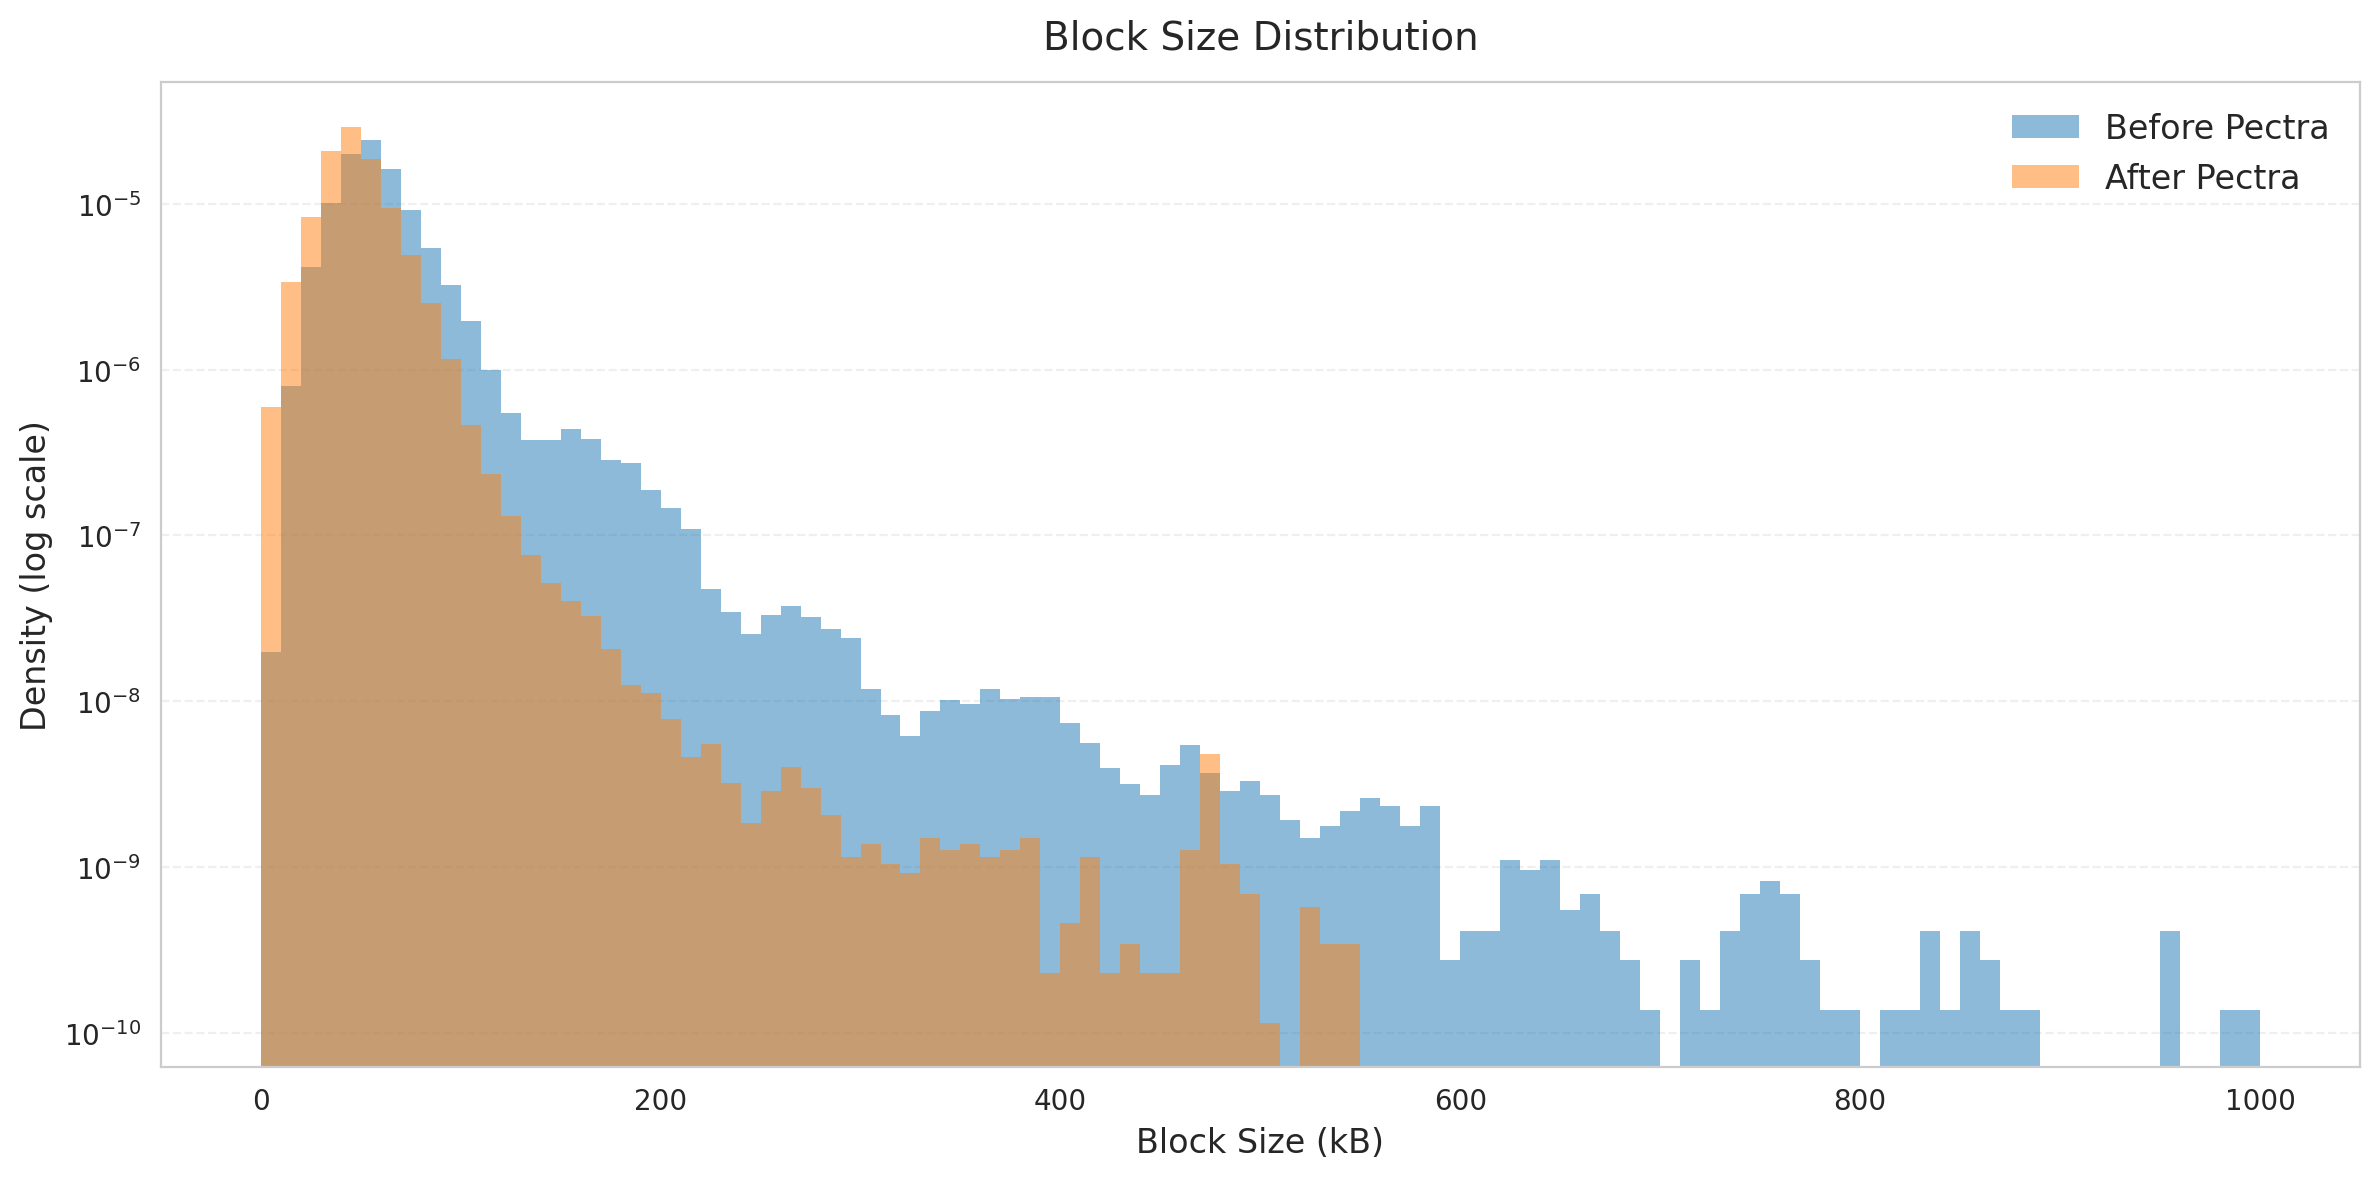

In [60]:
import seaborn as sns
import matplotlib.pyplot as plt


before = df_sizes.loc[df_sizes['slot'] < slot_pectra, 'block_size']
after  = df_sizes.loc[df_sizes['slot'] >= slot_pectra, 'block_size']
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(12, 6),dpi=200)
ax.hist(before, bins=100, range=(0, 1_000_000),
        alpha=0.5, label='Before Pectra',
        edgecolor='none', density=True)
ax.hist(after, bins=100, range=(0, 1_000_000),
        alpha=0.5, label='After Pectra',
        edgecolor='none', density=True)
ax.set_yscale('log')
ax.set_xlabel('Block Size (kB)', fontsize=12)
ax.set_ylabel('Density (log scale)', fontsize=12)
ax.set_title('Block Size Distribution', fontsize=14, pad=12)
ax.xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"{x/1000:.0f}"))
ax.tick_params(axis='x', labelsize=10)
ax.tick_params(axis='y', labelsize=10)
ax.grid(axis='y', linestyle='--', alpha=0.3)
ax.grid(axis='x', visible=False)
ax.legend(loc='upper right', fontsize=12, frameon=False)
plt.tight_layout()
plt.show()

In [61]:
df_sizes['block_size'].max()

np.uint32(1348880)


Mean: 0.0031691482911294375, Mean: 0.0032827155019779686,
 
Std: 0.001954487361005861, Std: 0.001187021251569722



/tmp/ipykernel_78285/2658079838.py:43: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


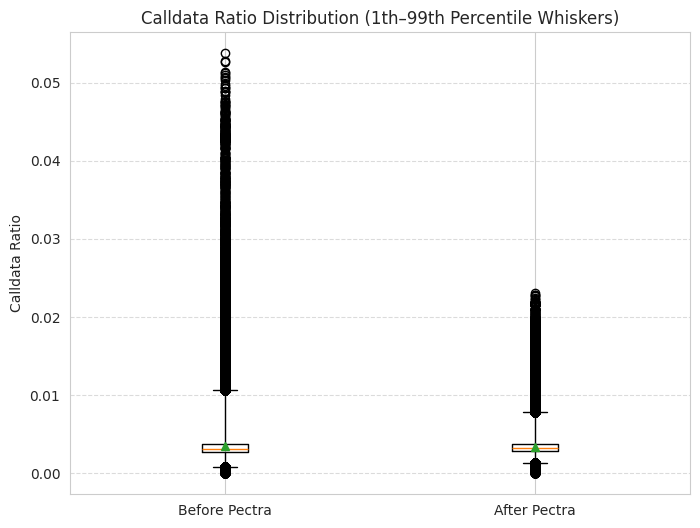

In [62]:
step = 5000
parts = []
for lo in range(block_start, block_end + 1, step): # Gas limit to 36M
    hi = min(lo + step - 1, block_end)
    q = f"""
        SELECT
            block_number,
            SUM(calldata_size) / SUM(gas_used) AS calldata_ratio
        FROM (
            SELECT
                block_number,
                transaction_hash,
                any(gas_used) as gas_used,
                any(n_input_bytes) AS calldata_size
            FROM default.canonical_execution_transaction
            WHERE block_number BETWEEN {lo} AND {hi}
            GROUP BY block_number, transaction_hash
        ) t
        GROUP BY block_number
        ORDER BY block_number
    """
    parts.append(client.query_df(q))

# Combine chunks; (groupby is just-in-case, blocks don't actually span chunks)
df = pd.concat(parts, ignore_index=True)
df = df.groupby('block_number', as_index=False)['calldata_ratio'].sum()
df.sort_values('block_number', ignore_index=True, inplace=True)

df

print(f"""
Mean: {df[df['block_number']< block_pectra]['calldata_ratio'].median()}, \
Mean: {df[df['block_number']>= block_pectra]['calldata_ratio'].median()},\n 
Std: {df[df['block_number']< block_pectra]['calldata_ratio'].std()}, \
Std: {df[df['block_number']>= block_pectra]['calldata_ratio'].std()}
""")

# Split into before and after
before = df[df['block_number'] <  block_pectra]['calldata_ratio']
after  = df[df['block_number'] >= block_pectra]['calldata_ratio']

plt.figure(figsize=(8, 6))
plt.boxplot(
    [before, after],
    labels=['Before Pectra', 'After Pectra'],
    showmeans=True,
    whis=(1, 99)  # whiskers span from 5th to 95th percentile
)
plt.ylabel('Calldata Ratio')
plt.title('Calldata Ratio Distribution (1th–99th Percentile Whiskers)')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.show()



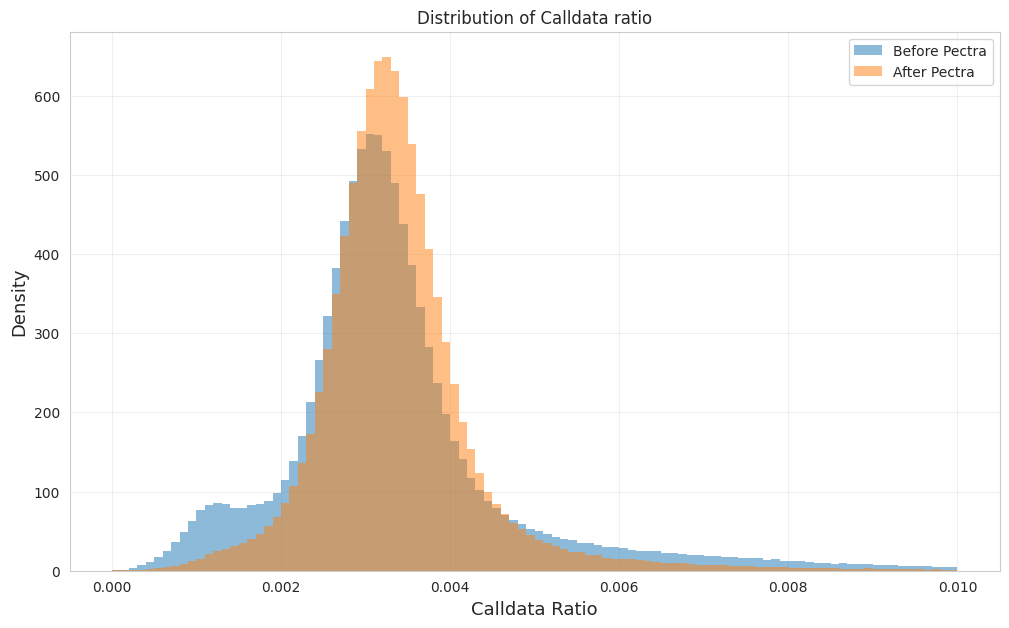

In [63]:
plt.figure(figsize=(12,7))
sns.set_style("whitegrid")

plt.title("Distribution of Calldata ratio")
plt.xlabel('Calldata Ratio', fontsize=13)
plt.ylabel('Density', fontsize=13)

plt.hist(before, range=(0,0.01), bins=100, alpha=0.5, density=True, edgecolor='none')
plt.hist(after, range=(0,0.01), bins=100, alpha=0.5, density=True, edgecolor='none')
plt.grid(axis='y', alpha=0.3)
plt.grid(axis='x', alpha=0.3)
plt.legend(['Before Pectra', 'After Pectra'])

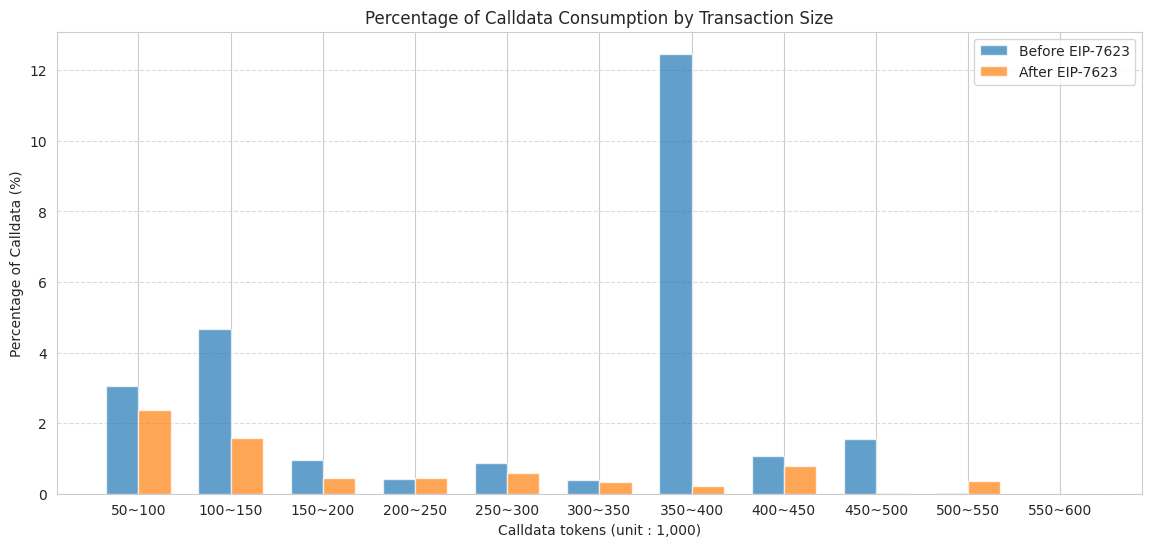

In [64]:
df_before_size = client.query_df(f"""
    SELECT 
        DISTINCT transaction_hash,
       ((n_input_zero_bytes) + (n_input_nonzero_bytes * 4)) as calldata_size

    FROM default.canonical_execution_transaction
    
    WHERE block_number BETWEEN {block_pectra-200000} AND {block_pectra}
       AND success = True
    ORDER BY calldata_size DESCENDING
""")

df_after_size = client.query_df(f"""
    SELECT 
        DISTINCT transaction_hash,
       ((n_input_zero_bytes) + (n_input_nonzero_bytes * 4)) as calldata_size
                
    FROM default.canonical_execution_transaction
    
    WHERE block_number BETWEEN {block_pectra} AND {block_pectra+200000}
        AND success = True
    ORDER BY block_number 
""")

# thresholds = [0,1000, 10000, 50000, 100000, 300000, 500000]
thresholds = [50000* i for i in range(1,12)]

def calculate_cumulative_percentage_above_threshold(df, threshold1, threshold2):
    if threshold == None:
        return 100 * df[df['calldata_size']>=threshold1]['calldata_size'].sum() / df['calldata_size'].sum()
    else:
        return 100 * df[(df['calldata_size']>=threshold1) & (df['calldata_size']<=threshold2)]['calldata_size'].sum() / df['calldata_size'].sum()

before_cumulative_percentages, after_cumulative_percentages = [],[]
for i,threshold in enumerate(thresholds):
    if i == len(thresholds)-1:
        before_cumulative_percentages.append(calculate_cumulative_percentage_above_threshold(df_before_size, threshold, None ))
        after_cumulative_percentages.append(calculate_cumulative_percentage_above_threshold(df_after_size, threshold, None ))
    else:
        before_cumulative_percentages.append(calculate_cumulative_percentage_above_threshold(df_before_size, threshold, thresholds[i+1] ))
        after_cumulative_percentages.append(calculate_cumulative_percentage_above_threshold(df_after_size, threshold, thresholds[i+1] ))

# Plotting the results
plt.figure(figsize=(14, 6))

# Bar chart for both before and after periods
bar_width = 0.35  # Width of bars
index = range(len(thresholds))  # Index for x-axis positions

plt.bar(index, before_cumulative_percentages, bar_width, label='Before EIP-7623', alpha=0.7)
plt.bar([i + bar_width for i in index], after_cumulative_percentages, bar_width, label='After EIP-7623', alpha=0.7)

# Customizing the plot
plt.xlabel('Calldata tokens (unit : 1,000)')
plt.ylabel('Percentage of Calldata (%)')
plt.title('Percentage of Calldata Consumption by Transaction Size')

plt.xticks([i + bar_width / 2 for i in index], [f"{50*i}~{50*(i+1)}" for i in range(1,12)])
plt.legend()
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.show()

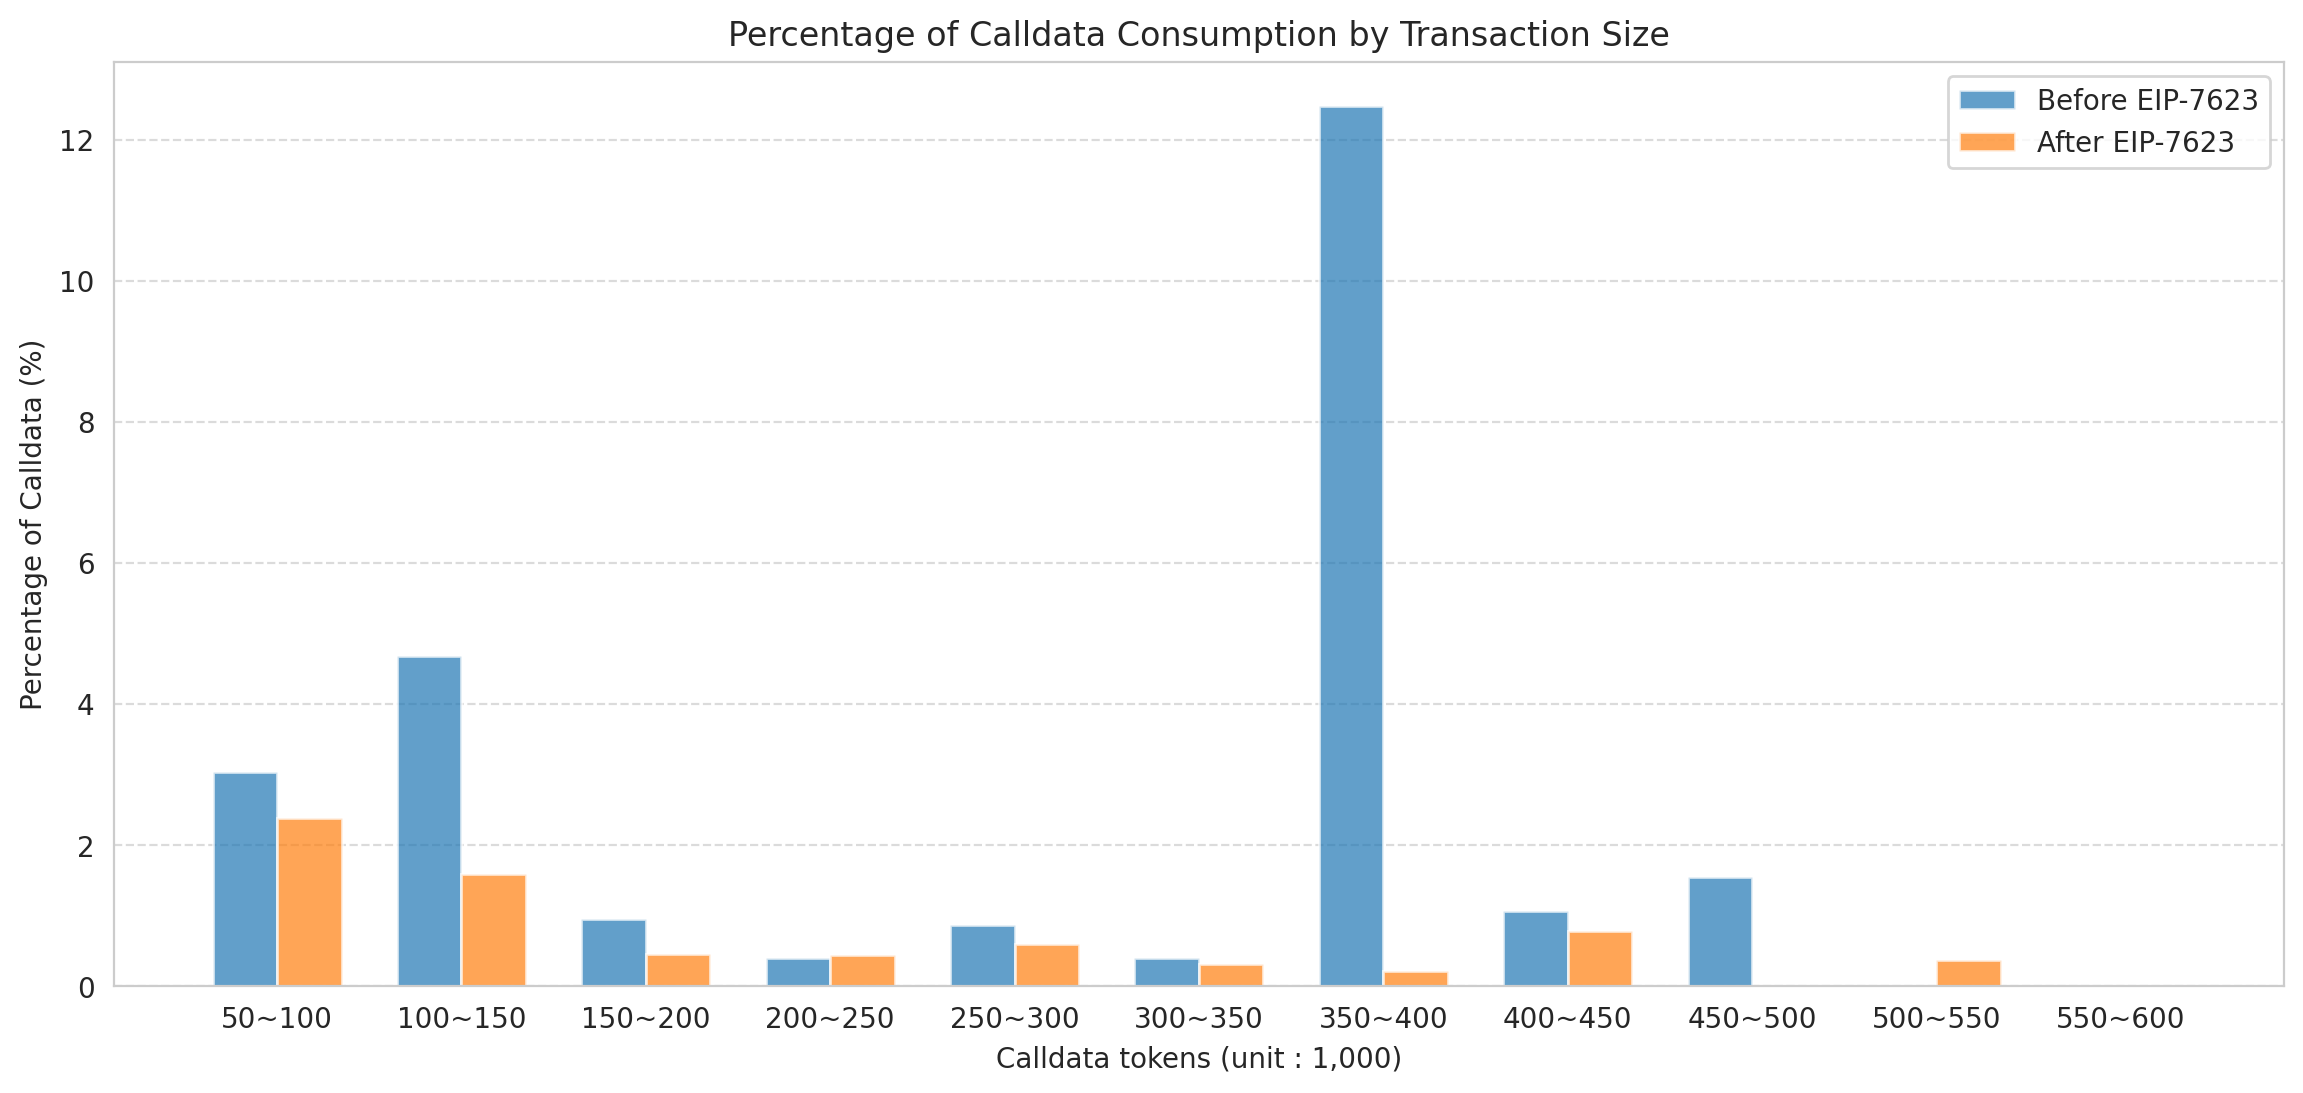

In [65]:
# Plotting the results
plt.figure(figsize=(14, 6),dpi=200)

# Bar chart for both before and after periods
bar_width = 0.35  # Width of bars
index = range(len(thresholds))  # Index for x-axis positions

plt.bar(index, before_cumulative_percentages, bar_width, label='Before EIP-7623', alpha=0.7)
plt.bar([i + bar_width for i in index], after_cumulative_percentages, bar_width, label='After EIP-7623', alpha=0.7)

# Customizing the plot
plt.xlabel('Calldata tokens (unit : 1,000)')
plt.ylabel('Percentage of Calldata (%)')
plt.title('Percentage of Calldata Consumption by Transaction Size')

plt.xticks([i + bar_width / 2 for i in index], [f"{50*i}~{50*(i+1)}" for i in range(1,12)])
plt.legend()
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.grid(False, axis='x')
plt.show()

block_size_bin
0–50       752875
50–100     886817
100–200     61902
200–300      3957
300–400       753
400–500       371
500+          244
Name: count, dtype: int64


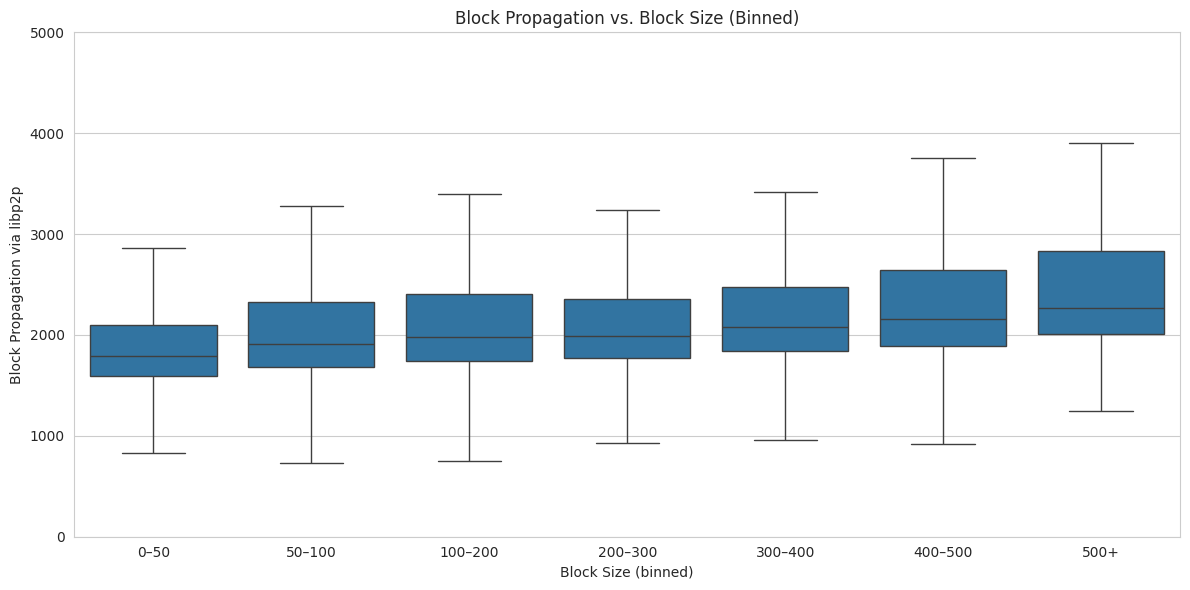

In [66]:
df_plot = total_df.dropna(subset=['block_size']).copy()

bin_edges = [0, 50_000, 100_000, 200_000, 300_000, 400_000, 500_000, df_plot['block_size'].max() + 1]
labels   = ['0–50','50–100','100–200','200–300','300–400','400–500','500+']

# Bin and enforce ordered categorical
df_plot['block_size_bin'] = pd.cut(
    df_plot['block_size'],
    bins=bin_edges,
    labels=labels,

    include_lowest=True
)
df_plot['block_size_bin'] = pd.Categorical(df_plot['block_size_bin'], categories=labels, ordered=True)

# (Optional) quick sanity check: counts per bin
bin_counts = df_plot['block_size_bin'].value_counts().sort_index()
print(bin_counts)

# Boxplot of block_prop_libp2p by size bin
plt.figure(figsize=(12, 6))
sns.boxplot(
    data=df_plot,
    x='block_size_bin',
    y='block_prop_libp2p',
    order=labels,
    fliersize=0  # faster & cleaner for large N; remove if you need outliers
)
plt.ylim(0,5000)
plt.xlabel('Block Size (binned)')
plt.ylabel('Block Propagation via libp2p')
plt.title('Block Propagation vs. Block Size (Binned)')
plt.tight_layout()
plt.show()

/tmp/ipykernel_78285/2150976649.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_plot.groupby('block_size_bin')['block_prop_libp2p']


block_size_bin
0–50       0.003937
50–100     0.001624
100–200    0.003086
200–300    0.004043
300–400    0.005312
400–500    0.008086
500+       0.020492
Name: block_prop_libp2p, dtype: float64


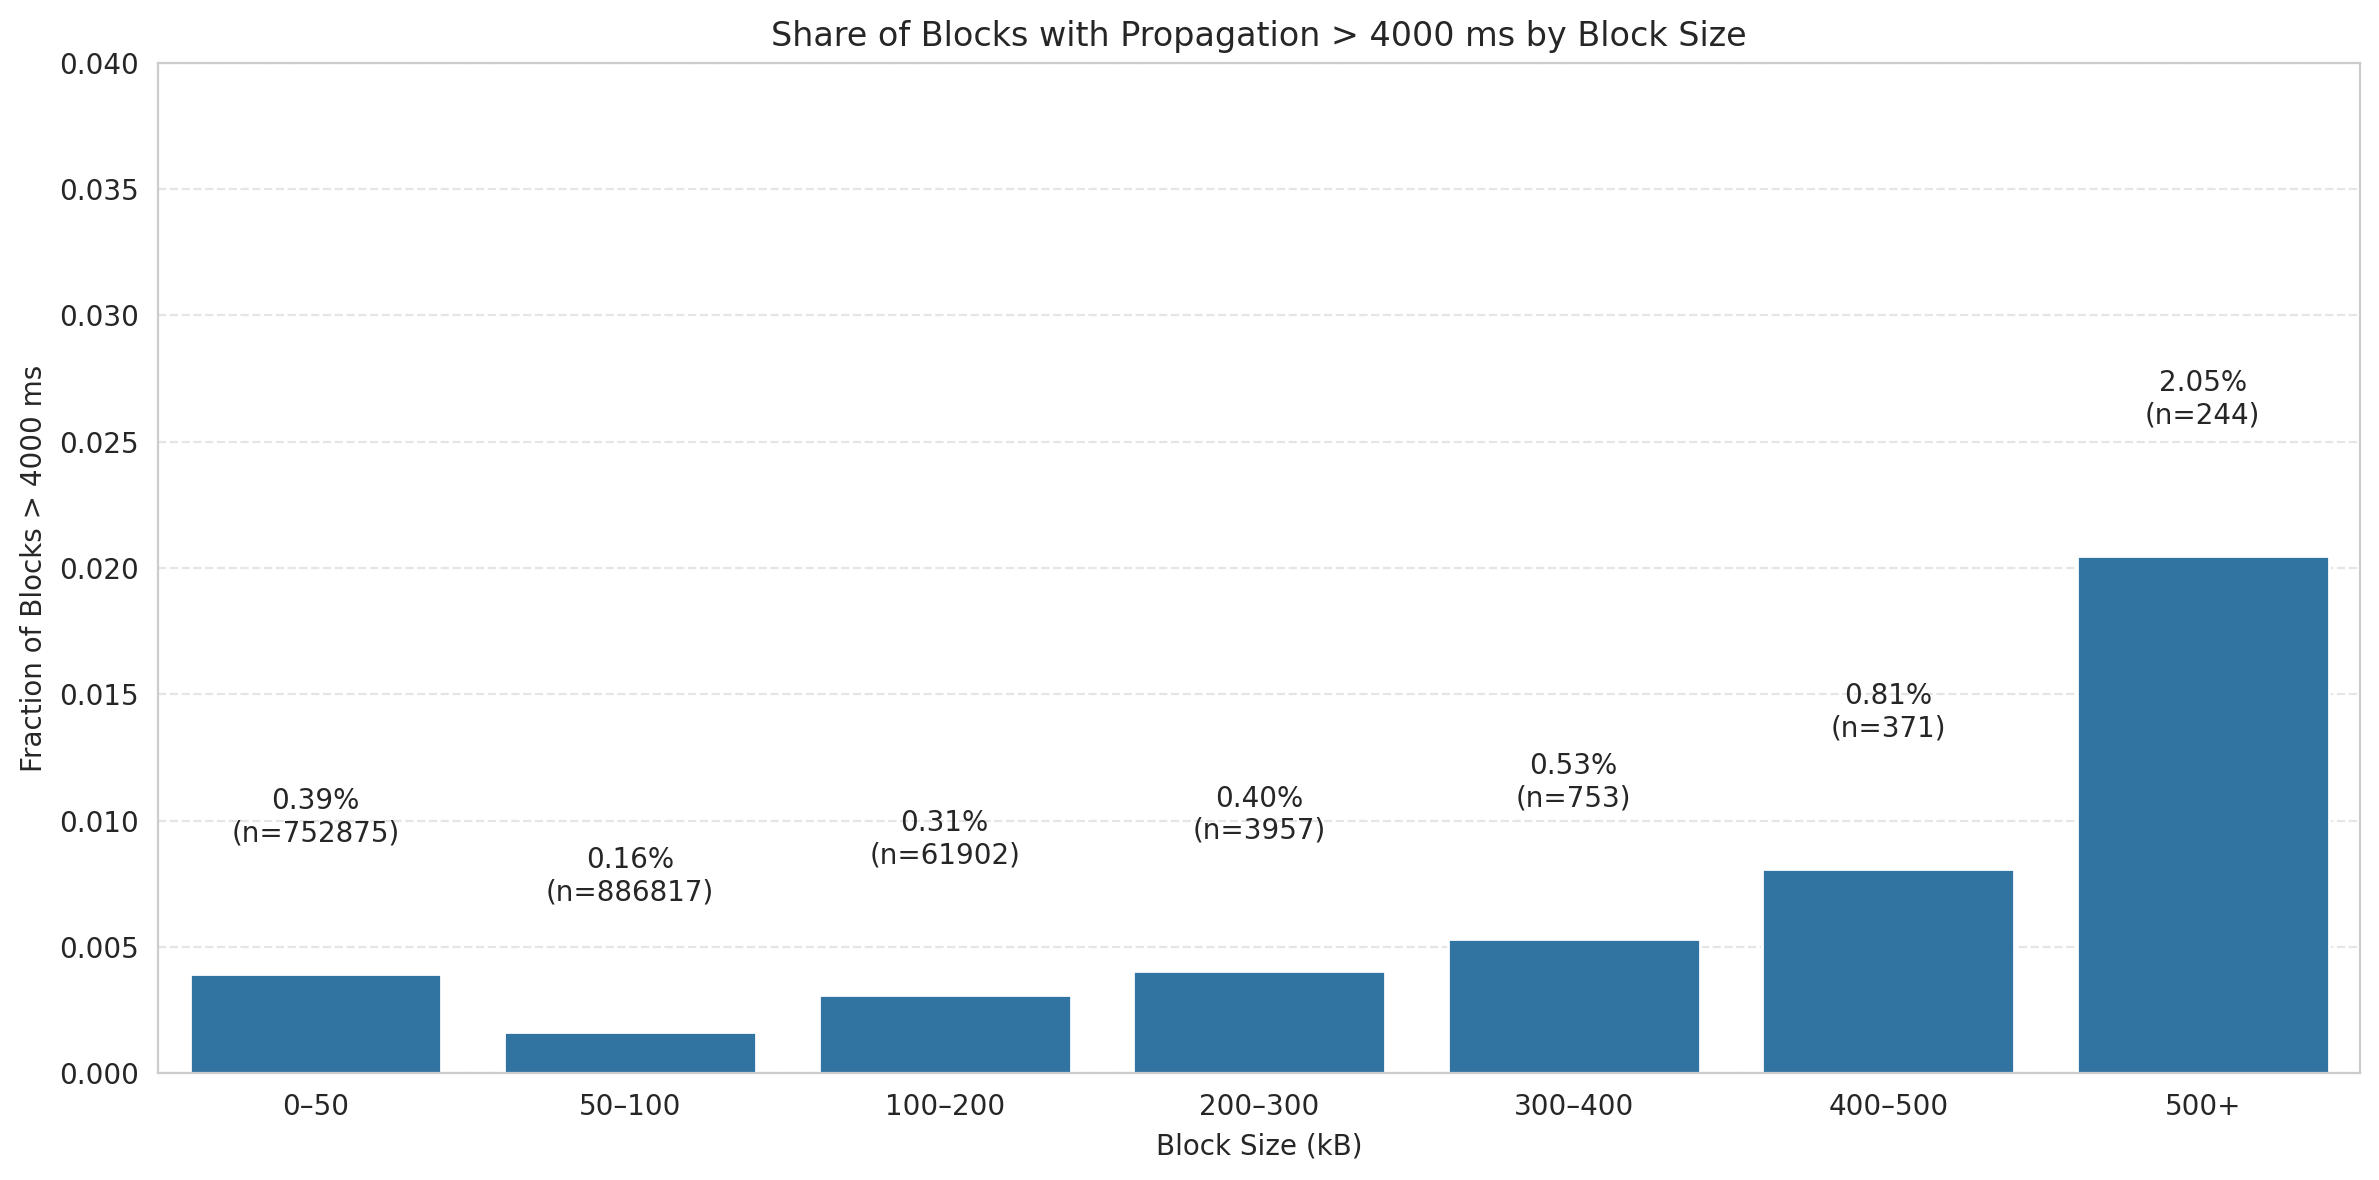

In [67]:

# Threshold
threshold = 4000  # ms

# Compute ratio per bin
ratio_per_bin = (
    df_plot.groupby('block_size_bin')['block_prop_libp2p']
    .apply(lambda x: (x > threshold).mean())  # mean of boolean = ratio
    .reindex(labels)  # ensure consistent order
)
print(ratio_per_bin)


counts = df_plot['block_size_bin'].value_counts().reindex(labels).fillna(0).astype(int)

plt.figure(figsize=(12, 6), dpi=200)
ax = sns.barplot(x=ratio_per_bin.index, y=ratio_per_bin.values, order=labels, color="tab:blue")

# Annotate ratio + n
for i, (val, n) in enumerate(zip(ratio_per_bin.values, counts)):
    ax.text(i, val + 0.005, f"{val:.2%}\n(n={n})", ha='center', va='bottom')

plt.ylabel("Fraction of Blocks > 4000 ms")
plt.xlabel("Block Size (kB)")
plt.title("Share of Blocks with Propagation > 4000 ms by Block Size")
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.ylim(0, 0.04)  # extra headroom for text
plt.tight_layout()
plt.show()

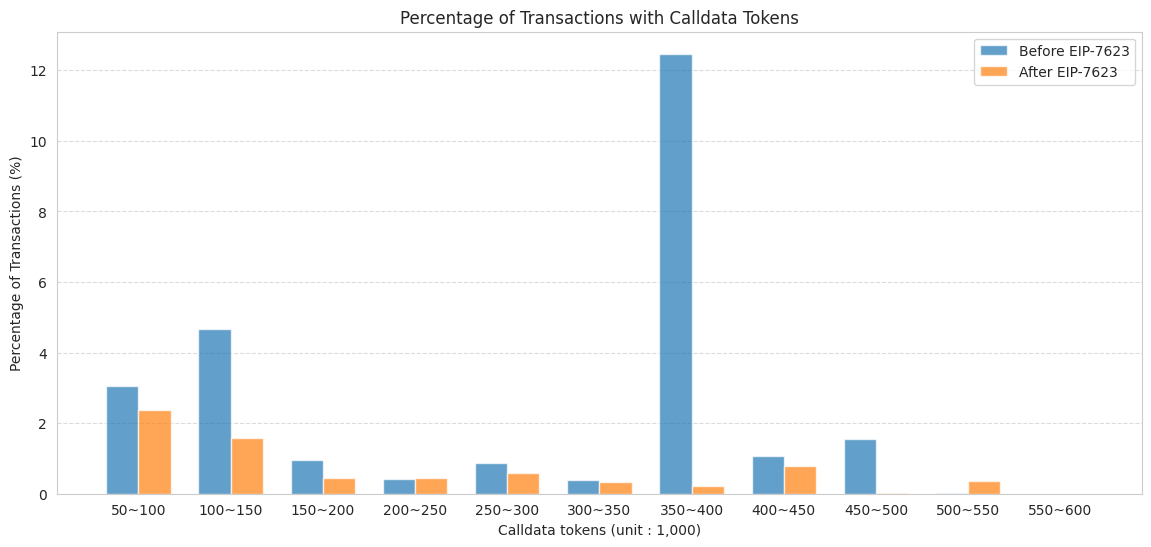

In [68]:
# Plotting the results
plt.figure(figsize=(14, 6))

# Bar chart for both before and after periods
bar_width = 0.35  # Width of bars
index = range(len(thresholds))  # Index for x-axis positions

plt.bar(index, before_cumulative_percentages, bar_width, label='Before EIP-7623', alpha=0.7)
plt.bar([i + bar_width for i in index], after_cumulative_percentages, bar_width, label='After EIP-7623', alpha=0.7)

# Customizing the plot
plt.xlabel('Calldata tokens (unit : 1,000)')
plt.ylabel('Percentage of Transactions (%)')
plt.title('Percentage of Transactions with Calldata Tokens')

plt.xticks([i + bar_width / 2 for i in index], [f"{50*i}~{50*(i+1)}" for i in range(1,12)])
plt.legend()
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.grid(False, axis='x')
plt.show()

### Validator Count

105792462.13218462 106942823.22971004


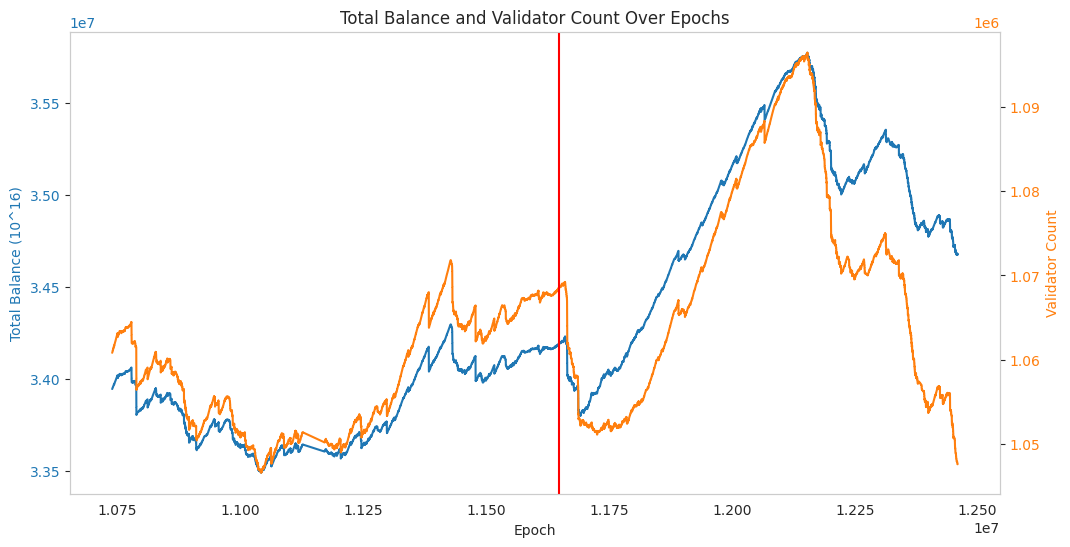

In [23]:
print(100*total_df[total_df['slot']<slot_pectra]['validator_count'].mean(), \
100*total_df[total_df['slot']>=slot_pectra]['validator_count'].mean())

fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot total_balance on primary y-axis
ax1.plot(total_df['slot'], total_df['total_balance'], color='tab:blue', label='Total Balance (10^16)')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Total Balance (10^16)', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()
ax2.plot(total_df['slot'], total_df['validator_count'], color='tab:orange', label='Validator Count')
ax2.set_ylabel('Validator Count', color='tab:orange')
ax2.tick_params(axis='y', labelcolor='tab:orange')

ax1.grid(False)
ax2.grid(False)

plt.axvline(slot_pectra, color='r')
plt.title('Total Balance and Validator Count Over Epochs')
plt.show()